# Прогнозирование температуры звезд

## Описание проекта
Необходимо придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами: закон смещения Вина, закон Стефана-Больцмана, спектральный анализ. Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.  

### Задача
Разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

### Описание данных 
Характеристики:
* Относительная светимость L/Lo — светимость звезды относительно Солнца.  
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.  
* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.  
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.  
* Тип звезды: 
    0. Коричневый карлик  
    1. Красный карлик  
    2. Белый карлик  
    3. Звёзды главной последовательности  
    4. Сверхгигант  
    5. Гипергигант

In [280]:
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

In [369]:
RANDOM_STATE = 42
MAX_EPOCHS = 20000

In [348]:
try:
    data = pd.read_csv('./datasets/6_class.csv', index_col=0)
except:
    data = pd.read_csv('/datasets/6_class.csv', index_col=0)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0             3068          0.002400        0.1700                   16.12   
1             3042          0.000500        0.1542                   16.60   
2             2600          0.000300        0.1020                   18.70   
3             2800          0.000200        0.1600                   16.65   
4             1939          0.000138        0.1030                   20.06   

   Star type Star color  
0          0        Red  
1          0        Red  
2          0        Red  
3          0        Red  
4          0        Red

Сразу можно заметить, что в датасете нет пропусков. Для дальнейшего удобства изменим названия колонок

In [349]:
data.rename(
    columns={
        'Temperature (K)': 'temperature',
        'Luminosity(L/Lo)': 'luminosity',
        'Radius(R/Ro)': 'radius',
        'Absolute magnitude(Mv)': 'abs_magnitude',
        'Star type': 'star_type',
        'Star color': 'star_color',
    },
    inplace=True
)
data.head ()

temperature  luminosity  radius  abs_magnitude  star_type star_color
0         3068    0.002400  0.1700          16.12          0        Red
1         3042    0.000500  0.1542          16.60          0        Red
2         2600    0.000300  0.1020          18.70          0        Red
3         2800    0.000200  0.1600          16.65          0        Red
4         1939    0.000138  0.1030          20.06          0        Red

## EDA

Первичный анализ выполним с помощью библиотеки `ydata_profiling`

In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Из данного анализа можно сделать следующие выводы:
1. В предоставленном датасете нет пропущенных значений и явных дубликатов.  
2. Целевой признак `temperature` имеет нормальное распределение с длинным правым хвостом. Признак имеет большую дисперсию.
3. Признаки `luminosity` и `radius` также имеют распределение, похожее на нормальное с длинным правым хвостом. Эти признаки также имеют большую дисперсию.  
4. Признак `abs_magnitude` имеет бимодальное распеределение.  
5. При рассмотрении категориальной переменной `star_type` можно сделать вывод, что датасет стратифицирован по типу звезды, так как в каждой категории содержится равное количество экземпляров.  
6. Категориальный признак `star_color` содержит неявные дубликаты, который необходимо устранить. Также она содержит очень мелкие категории, который можно попытаться объединить.

Обработаем неявные дубликаты признака `star_color`

In [350]:
data['star_color'].value_counts()

star_color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: count, dtype: int64

Выполним следующие преобразования:
1. Приведем весь текст к нижнему регистру.  
2. Заменим пробелы на дефис.  
3. Удалим пробелы в начале и конце текста.  
4. Объединим мелкие категории. Например, заменим все `yellowish` на `yellow`, `whitish` на `white`, удалим приставки такие как `pale`
5. Избавимся от таких неявных дубликатов, как `white-yellow`, `yellow-white`

In [351]:
# Приводим к нижнему регистру
data['star_color'] = data['star_color'].str.lower()
# Удалям лишние пробелы в начале и в конце
data['star_color'] = data['star_color'].str.strip()
# Заменяем пробелы между слов на дефисы
data['star_color'] = data['star_color'].str.replace(' ', '-')

# Объединяем мелкие категории
data['star_color'] = data['star_color'].str.replace('yellowish', 'yellow')
data['star_color'] = data['star_color'].str.replace('whitish', 'white')
data['star_color'] = data['star_color'].str.replace('white-yellow', 'yellow-white')
data['star_color'] = data['star_color'].str.replace('pale-yellow-orange', 'yellow')
data['star_color'] = data['star_color'].str.replace('orange-red', 'orange')

In [352]:
data['star_color'].value_counts()

star_color
red             112
blue             56
blue-white       41
white            12
yellow-white     12
yellow            4
orange            3
Name: count, dtype: int64

В итоге получили 7 категорий. Однако количество экземляров между ними распределено крайне неравномерно, что потенциально может быть проблемой

Построим графики попарных зависимостей признаков. Также расскрасим точки в зависимости от категории

d:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

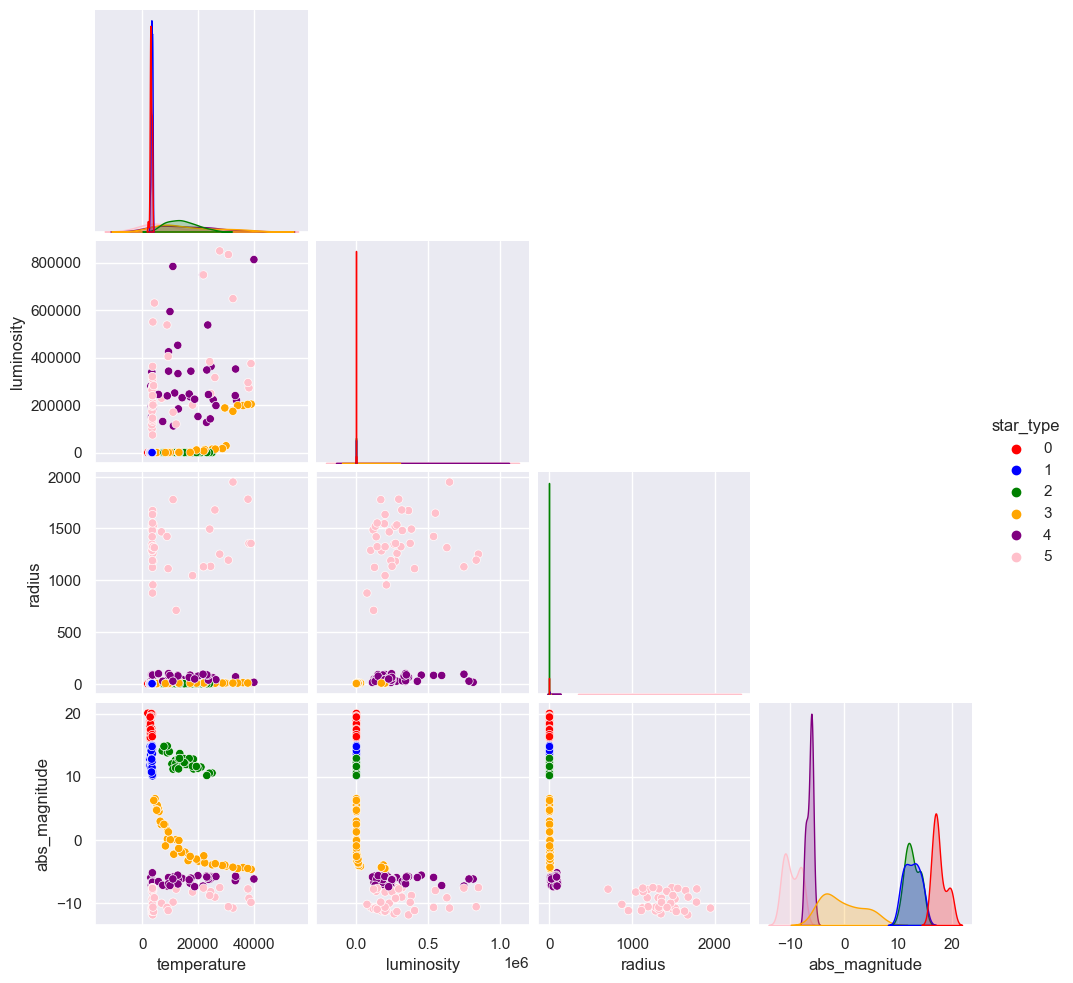

In [8]:
color_type = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'pink'
}
sns.set_theme()
sns.pairplot(data, hue='star_type', corner=True, palette=color_type)

Из полученного графика можно сделать следующие выводы:
1. Целевой признак `temperature` не зависит от признаков `luminosity`, `radius`. Также не зависимости от этих признаков внутри каждого типа звезд.  
2. Можно увидеть некоторую зависимость целевого признака `temperature` от признака `abs_magnitude` внутри каждого типа звезд:
    * У типов `0`, `1`, `4` и `5` можно предположить линейную зависимость с малым коофициентом  
    * у типа `2` лучше прослеживается линейная зависимость  
    * У типа `3` прослеживается экспоненциальная зависимость 
3. Зависимости между остальными переменными не наблюдается  
4. Радиус звезды в основном зависит от ее типа

Построим графики попарных зависимостей признаков. Также расскрасим точки в зависимости от цвета звезды

d:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\practicum\data_science\temperature_stars\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

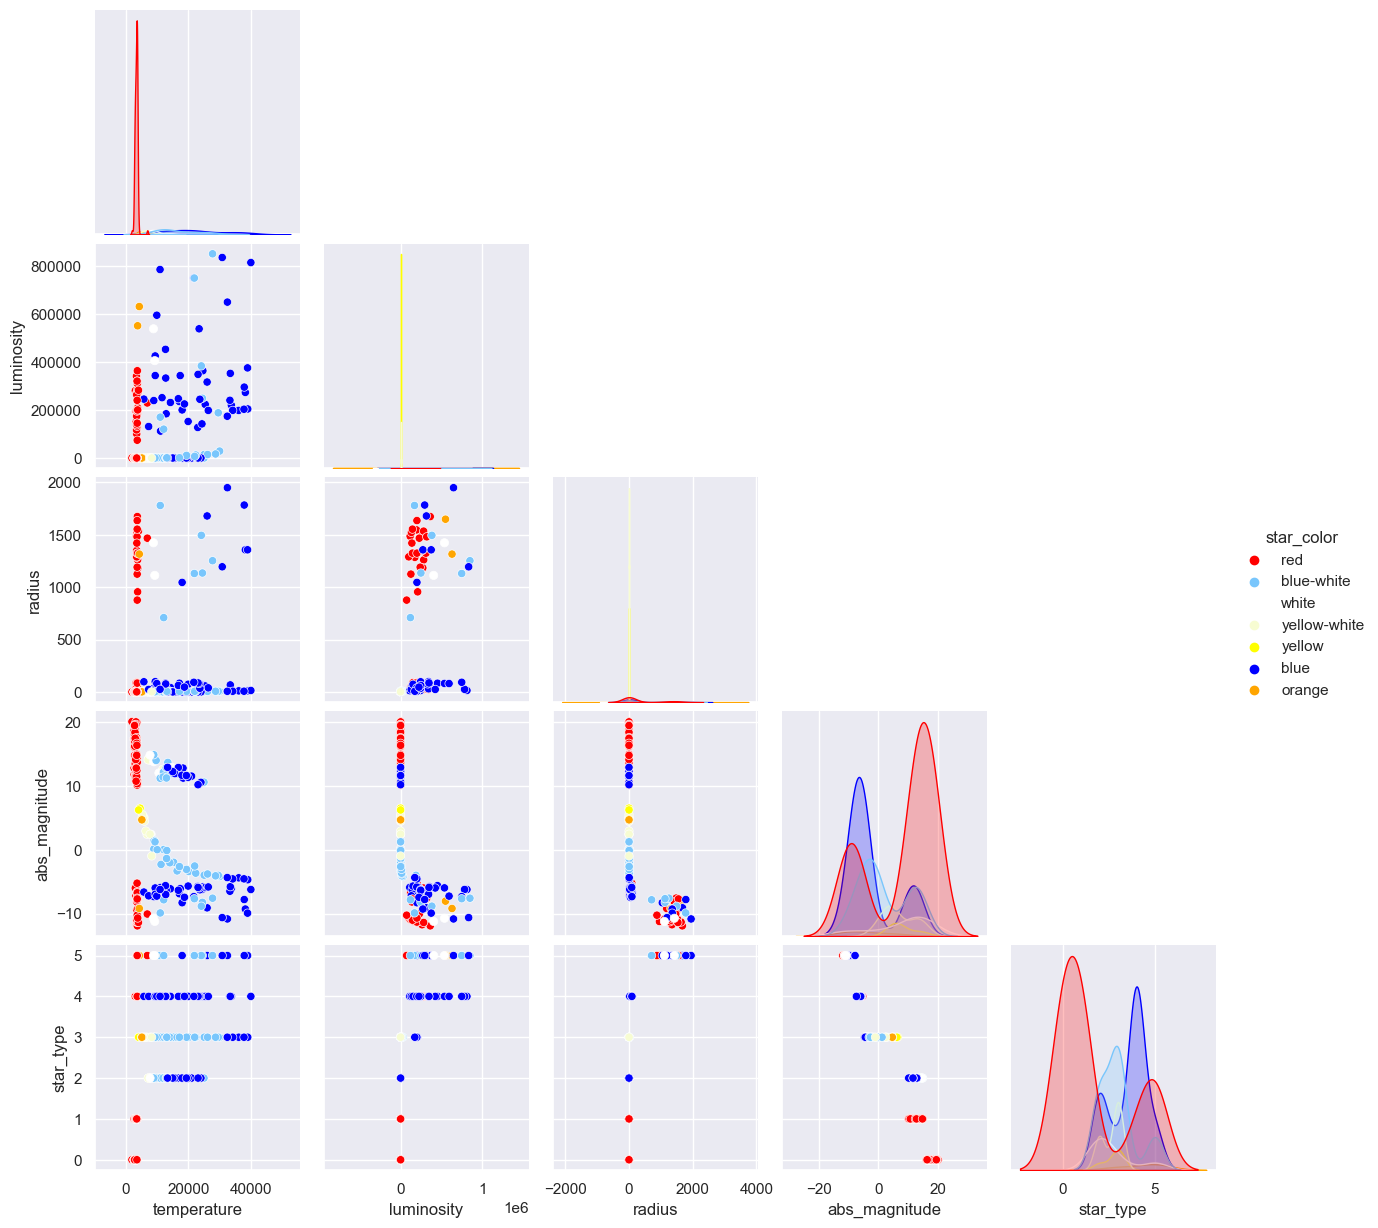

In [9]:
color_color = {
    'red': 'red',
    'blue': 'blue',
    'white': 'white',
    'yellow': 'yellow',
    'orange': 'orange',
    'blue-white': '#79c6fc',
    'yellow-white': '#f7fcd2'
}

sns.set_theme()
sns.pairplot(data, hue='star_color', corner=True, palette=color_color)

По графику зависимости температуры от типа звезды можно заметить, что звезды `0` и `1` самые холодные. Также они имеют наименьший разброс температур. Синие звезды самые горячие.

Text(0.5, 0, 'Тип звезды')

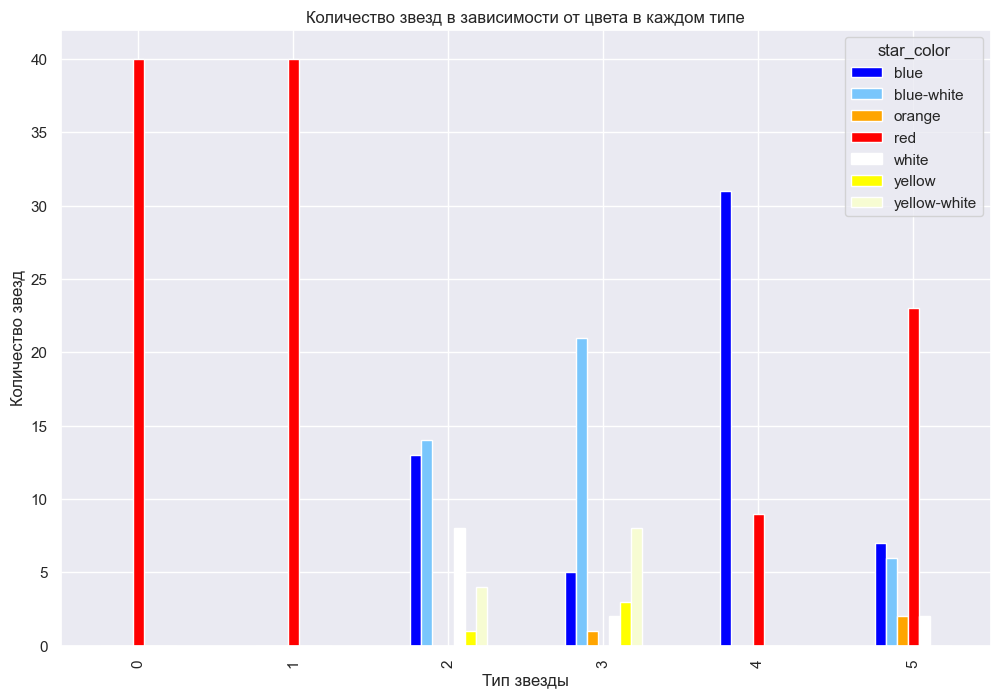

In [10]:
ax = pd.crosstab(data['star_type'], data['star_color']).plot.bar(figsize=(12, 8), color=color_color)
ax.set_title('Количество звезд в зависимости от цвета в каждом типе')
ax.set_ylabel('Количество звезд')
ax.set_xlabel('Тип звезды')

1. В категориях `0`, `1` находятся только звезды красного оттенка, что соотносится с названием категорий `Коричневый карлик` и `Красный карлик` соответственно.  
2. В категории `2` (`Белый карлик`) присутствуют звезды белого, желтого, бело-синего оттенков. Что вполне соотносится с типом звезды. Однако также присутсвуют звезды синего оттенка.  
3. В категориях `3` (`Звёзды главной последовательности`) и `5` (`Гипергигант`) присутствуют звезды всех оттенков.  
4. В категории `4` (`Сверхгигант`) присутствуют звезды синего и красного оттенков

Проверим распределение температуры в зависимости от типа звезды

<Axes: xlabel='temperature', ylabel='star_type'>

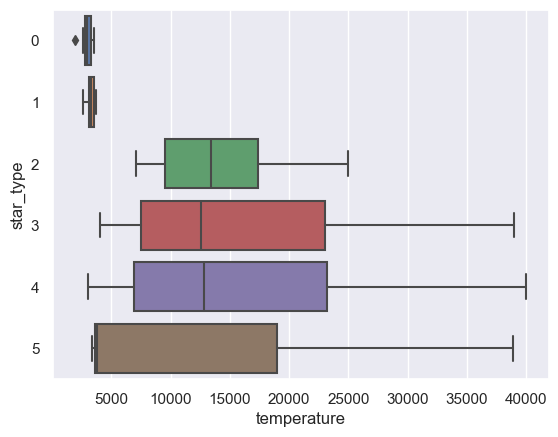

In [11]:
sns.boxplot(data=data, x='temperature', y='star_type', orient='h')

Проверим распределение температуры в зависимости от цвета звезды

<Axes: xlabel='temperature', ylabel='star_color'>

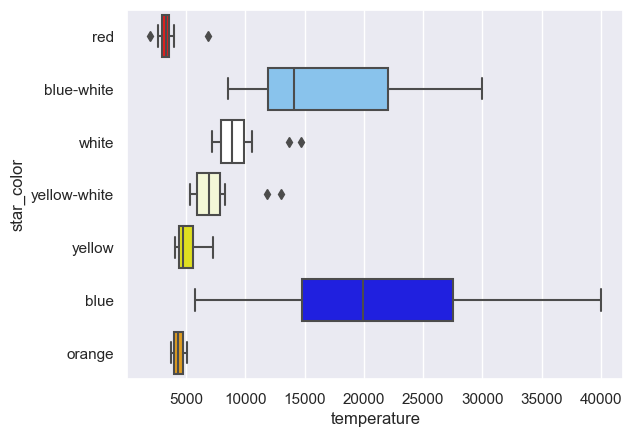

In [12]:
sns.boxplot(data=data, x='temperature', y='star_color', orient='h', palette=color_color)

По графику видно, что оранжевые звезды имеют примерно такое же распределение температуры, как и желтые. Также Оранжевые звезды содержатся в тех же типах звезд, что и желтые. Так как желтые и оранжевые звезды представляют собой малочисленные категории, то объединим их в одну категорию.

In [353]:
data['star_color'] = data['star_color'].str.replace('orange', 'yellow')

## Подготовка данных

In [355]:
def ohe(df, encoder, columns):
    encoder_columns = pd.DataFrame(
        encoder.transform(df[columns]).toarray(),
        index=df.index,
        columns=encoder.get_feature_names_out()
    )
    df = df.join(encoder_columns)
    return df.drop(columns, axis=1)

При разделении датасета на выборки используем стратификацию по цвету звезды. Был выбран вариант стратификации именно по цвету, а не по типу из-за того, что в выборке находится равное количество объектов каждого класса, а вот по цветам наблюдается сильный дисбаланс

In [356]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(['temperature'], axis=1), data['temperature'], test_size=.3,
    random_state=RANDOM_STATE, stratify=data[['star_color']]
)

In [357]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=.5,
    random_state=RANDOM_STATE, stratify=features_test[['star_color']]
)

In [358]:
ohe_encoder = OneHotEncoder(drop='first')

In [359]:
ohe_encoder.fit(features_train[['star_type', 'star_color']])

OneHotEncoder(drop='first')

In [360]:
features_train = ohe(features_train, ohe_encoder, ['star_type', 'star_color'])
features_valid = ohe(features_valid, ohe_encoder, ['star_type', 'star_color'])
features_test = ohe(features_test, ohe_encoder, ['star_type', 'star_color'])

In [361]:
numeric = ['luminosity', 'radius', 'abs_magnitude']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [362]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [363]:
features_train = torch.FloatTensor(features_train.values)
target_train = torch.FloatTensor(target_train.values)
features_valid = torch.FloatTensor(features_valid.values)
target_valid = torch.FloatTensor(target_valid.values)
features_test = torch.FloatTensor(features_test.values)
target_test = torch.FloatTensor(target_test.values)

## Экспериметы с моделью нейронной сети

In [364]:
class StarTemperatureNet(nn.Module):
    def __init__(
        self, input_size, hidden_size_1=None, act_1=None, reg_1=None,
        hidden_size_2=None, act_2=None, reg_2=None,
        hidden_size_3=None, act_3=None, reg_3=None,
        name = ''
    ):
        super(StarTemperatureNet, self).__init__()
        out_size = 1
        self.fc1 = nn.Linear(input_size, hidden_size_1 if hidden_size_1 else out_size)
        self.act1 = act_1
        self.reg1 = reg_1
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2 if hidden_size_2 else out_size) if hidden_size_1 else None
        self.act2 = act_2
        self.reg2 = reg_2
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3 if hidden_size_3 else out_size) if hidden_size_2 else None
        self.act3 = act_3
        self.reg3 = reg_3
        self.fc4 = nn.Linear(hidden_size_3, out_size) if hidden_size_3 else None
        
        self.name = name
    
    def forward(self, x):
        out = self.fc1(x)
        if self.reg1: out = self.reg1(out)
        if self.act1: out = self.act1(out)
        if self.fc2: out = self.fc2(out)
        if self.reg2: out = self.reg2(out)
        if self.act2: out = self.act2(out)
        if self.fc3: out = self.fc3(out)
        if self.reg3: out = self.reg3(out)
        if self.act3: out = self.act3(out)
        if self.fc4 : out = self.fc4(out)
        return out

In [365]:
def predict_fact_schedule(pred, target):
    x = np.arange(len(pred))
    _, ax = plt.subplots(figsize=(14, 8))
    ax.set_xticks(x)
    ax.bar(x, target, width = 0.8, label = 'Фактическое значение')
    ax.bar(x, pred, width = 0.5, label = 'Прогноз')
    ax.legend()
    ax.set_title('График Факт-прогноз')
    ax.set_xlabel('Звезда')
    ax.set_ylabel('Температура звезды')
    plt.show()

In [366]:
def train_net(
    model, X_train, y_train, X_valid, y_valid, 
    learning_rate=.001, num_epoch=10000, 
    min_loss_delta=100, max_counter=10
):
    counter = 0 # Cчётчик для ранней остановки обучения
    
    train_losses = []
    valid_losses = []
    schedule_epochs = []
    prev_loss_value = 0
    
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epoch):
        model.train()
        # Прямой проход
        outputs = model(X_train).flatten()
        loss_value = loss(outputs, y_train)
        # Обратный проход
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        
        if (epoch+1) % 100 == 0 or epoch == num_epoch - 1:
            with torch.no_grad():
                rmse_train = torch.sqrt(loss_value)
                pred_valid = model(X_valid).flatten()
                loss_value_valid = loss(pred_valid, y_valid)
                rmse_valid = torch.sqrt(loss_value_valid)
                train_losses.append(rmse_train.item())
                valid_losses.append(rmse_valid.item())
                schedule_epochs.append(epoch)
                print(f'Эпоха №{epoch+1}. RMSE_train: {rmse_train:.2f}. RMSE_valid: {rmse_valid:.2f}')
        
        delta = torch.abs(prev_loss_value - loss_value).item()
        if delta < min_loss_delta:
            counter += 1
            if counter > max_counter:
                print('Ранняя остановка')
                break
        else:
            counter = 0
        prev_loss_value = loss_value
    df_schedule = pd.DataFrame({'train': train_losses, 'valid': valid_losses, 'epoch': schedule_epochs})
    df_schedule.plot(
        x='epoch', figsize=(8, 12), grid=True,
        title=f'Качество НС({model.name}) в зависимости от эпохи',
        ylabel='RMSE', xlabel='Эпоха' 
    )
    predict_fact_schedule(model(X_valid).flatten().detach().numpy(), y_valid)

### Архитектура `13-20-ReLU-1`

Проведем эксперимент с НС с одним скрытым слоем и функцией активации `ReLU`. Входной слой будет содержать 13 входных нейронов (количество признаков). Скрытый слой будет содержать 20 нейронов. Выходной слой содержит 1 нейрон. Дадим НС незвание `13-20-relu-1`  
В дальнейшем НС будут именоваться по этому же принципу

In [370]:
test_model = StarTemperatureNet(
    input_size=features_test.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    name='13-20-relu-1'
)

Эпоха №100. RMSE_train: 14526.86. RMSE_valid: 12658.35
Эпоха №200. RMSE_train: 14465.77. RMSE_valid: 12608.99
Эпоха №300. RMSE_train: 14353.34. RMSE_valid: 12520.39
Эпоха №400. RMSE_train: 14193.09. RMSE_valid: 12397.71
Эпоха №500. RMSE_train: 13989.96. RMSE_valid: 12244.39
Эпоха №600. RMSE_train: 13752.33. RMSE_valid: 12064.98
Эпоха №700. RMSE_train: 13485.78. RMSE_valid: 11862.44
Эпоха №800. RMSE_train: 13194.30. RMSE_valid: 11639.63
Эпоха №900. RMSE_train: 12881.64. RMSE_valid: 11399.73
Эпоха №1000. RMSE_train: 12552.33. RMSE_valid: 11146.96
Эпоха №1100. RMSE_train: 12211.66. RMSE_valid: 10886.58
Эпоха №1200. RMSE_train: 11865.13. RMSE_valid: 10623.92
Эпоха №1300. RMSE_train: 11517.61. RMSE_valid: 10363.23
Эпоха №1400. RMSE_train: 11173.61. RMSE_valid: 10108.40
Эпоха №1500. RMSE_train: 10837.02. RMSE_valid: 9862.67
Эпоха №1600. RMSE_train: 10510.98. RMSE_valid: 9628.48
Эпоха №1700. RMSE_train: 10197.90. RMSE_valid: 9407.60
Эпоха №1800. RMSE_train: 9899.48. RMSE_valid: 9201.32
Эпоха 

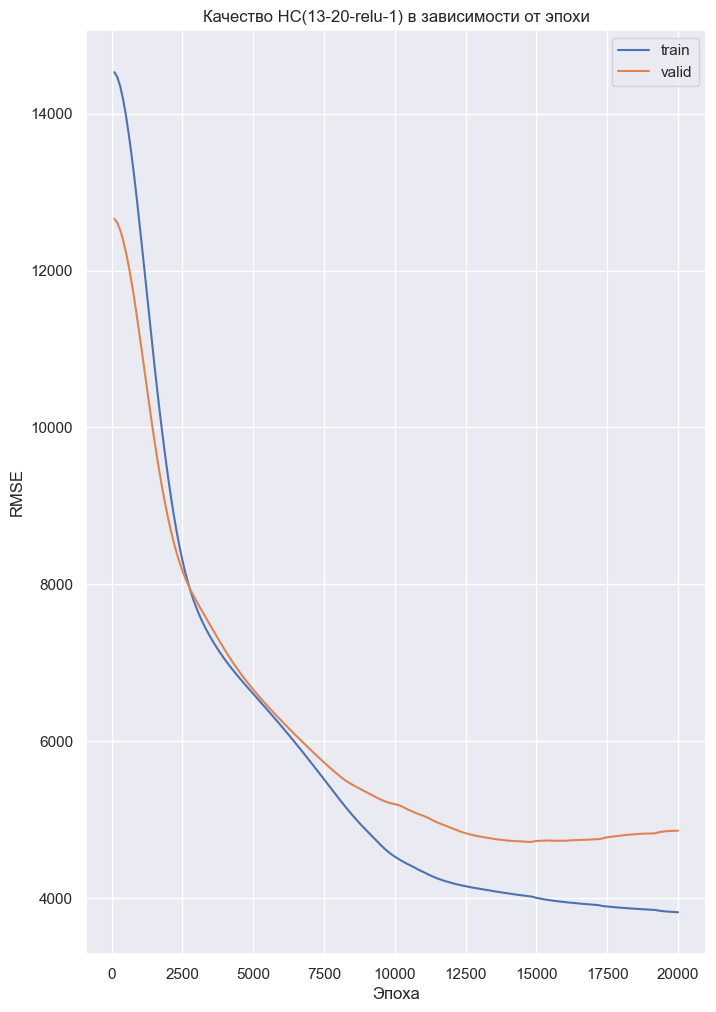

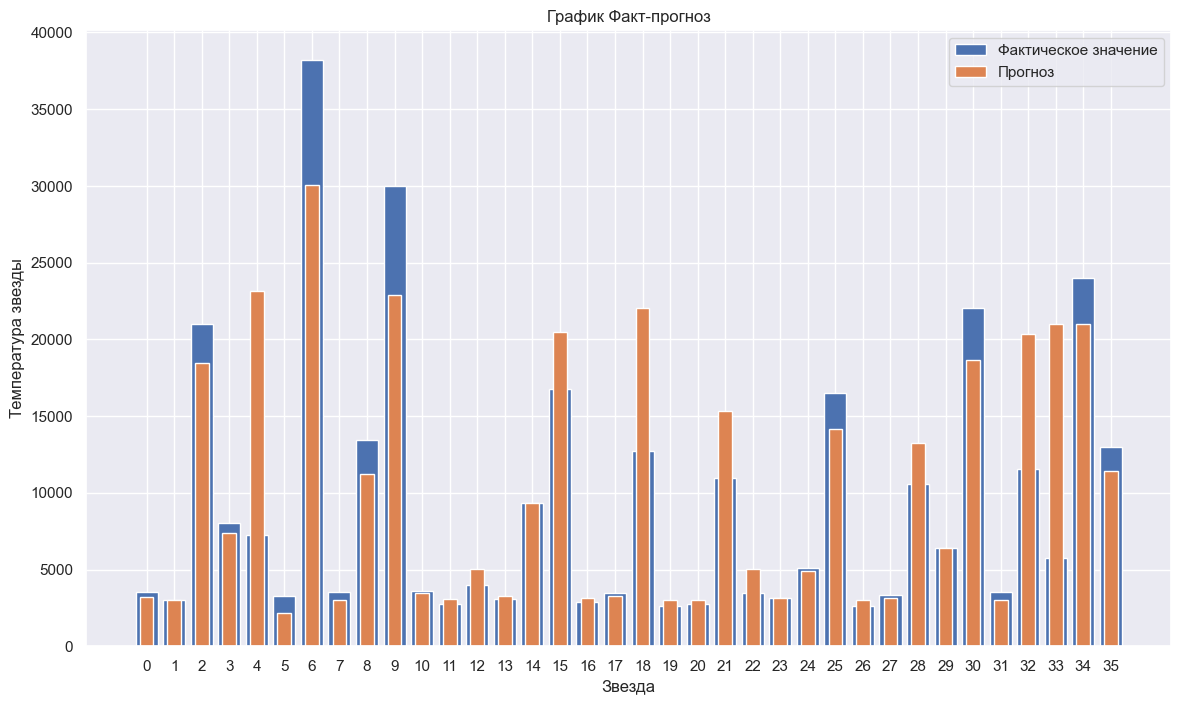

In [371]:
train_net(
    model=test_model,
    X_train=features_train, y_train=target_train,
    X_valid=features_valid, y_valid=target_valid,
    num_epoch=MAX_EPOCHS, learning_rate=.005
)

По графику обучения видно, что примерно после 15000 эпох сеть начала переобучаться: метрика на тренировочной выборке продолжала уменьшаться, а на валидационной начала увеличиваться. По графику Факт-Прогноз видно, что звезды , которые имеют температуру до 10000К предстказываются неплохо. А вот со звездами большей температуру у НС возникают проблемы.

### Архитектура `13-20-ReLU-12-ReLU-1`

In [389]:
test_model = StarTemperatureNet(
    input_size=features_test.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    hidden_size_2=12, act_2=nn.ReLU(),
    name='13-20-relu-12-relu-1'
)

Эпоха №100. RMSE_train: 14422.88. RMSE_valid: 12572.12
Эпоха №200. RMSE_train: 13049.30. RMSE_valid: 11464.53
Эпоха №300. RMSE_train: 10010.49. RMSE_valid: 9074.91
Эпоха №400. RMSE_train: 7855.04. RMSE_valid: 7678.50
Эпоха №500. RMSE_train: 7200.84. RMSE_valid: 7358.67
Эпоха №600. RMSE_train: 6887.04. RMSE_valid: 7113.71
Эпоха №700. RMSE_train: 6641.83. RMSE_valid: 6885.63
Эпоха №800. RMSE_train: 6422.11. RMSE_valid: 6679.59
Эпоха №900. RMSE_train: 6212.78. RMSE_valid: 6492.02
Эпоха №1000. RMSE_train: 6005.64. RMSE_valid: 6321.84
Эпоха №1100. RMSE_train: 5796.77. RMSE_valid: 6163.75
Эпоха №1200. RMSE_train: 5585.55. RMSE_valid: 6014.79
Эпоха №1300. RMSE_train: 5373.48. RMSE_valid: 5877.29
Эпоха №1400. RMSE_train: 5166.96. RMSE_valid: 5757.41
Эпоха №1500. RMSE_train: 4970.21. RMSE_valid: 5654.76
Эпоха №1600. RMSE_train: 4789.91. RMSE_valid: 5570.83
Эпоха №1700. RMSE_train: 4635.96. RMSE_valid: 5508.22
Эпоха №1800. RMSE_train: 4510.20. RMSE_valid: 5458.69
Эпоха №1900. RMSE_train: 4412.16

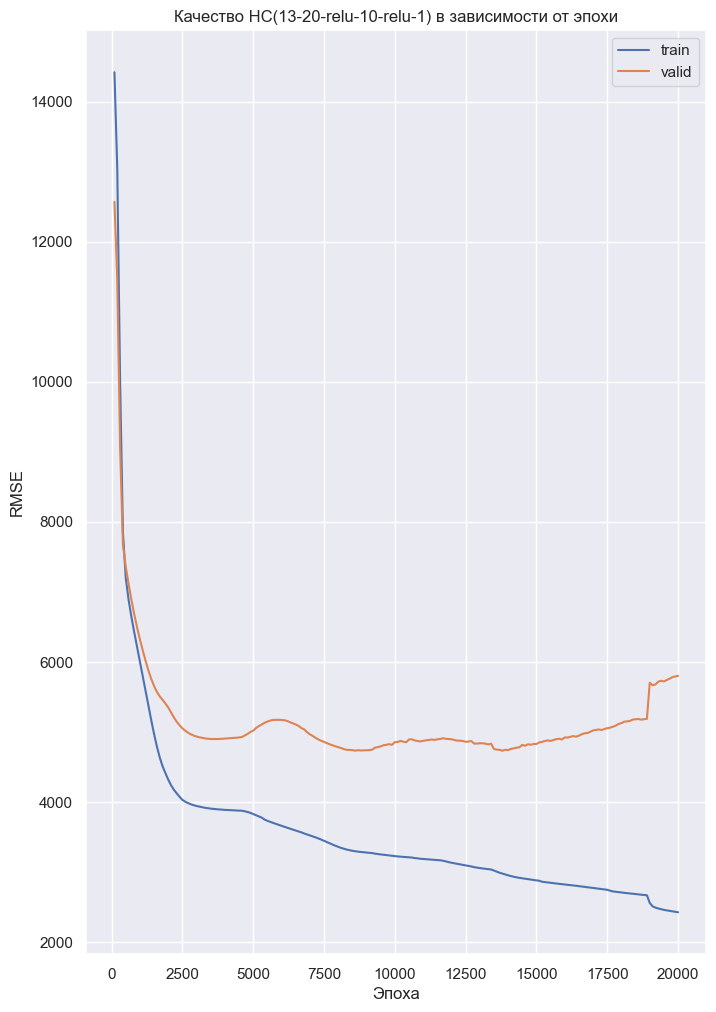

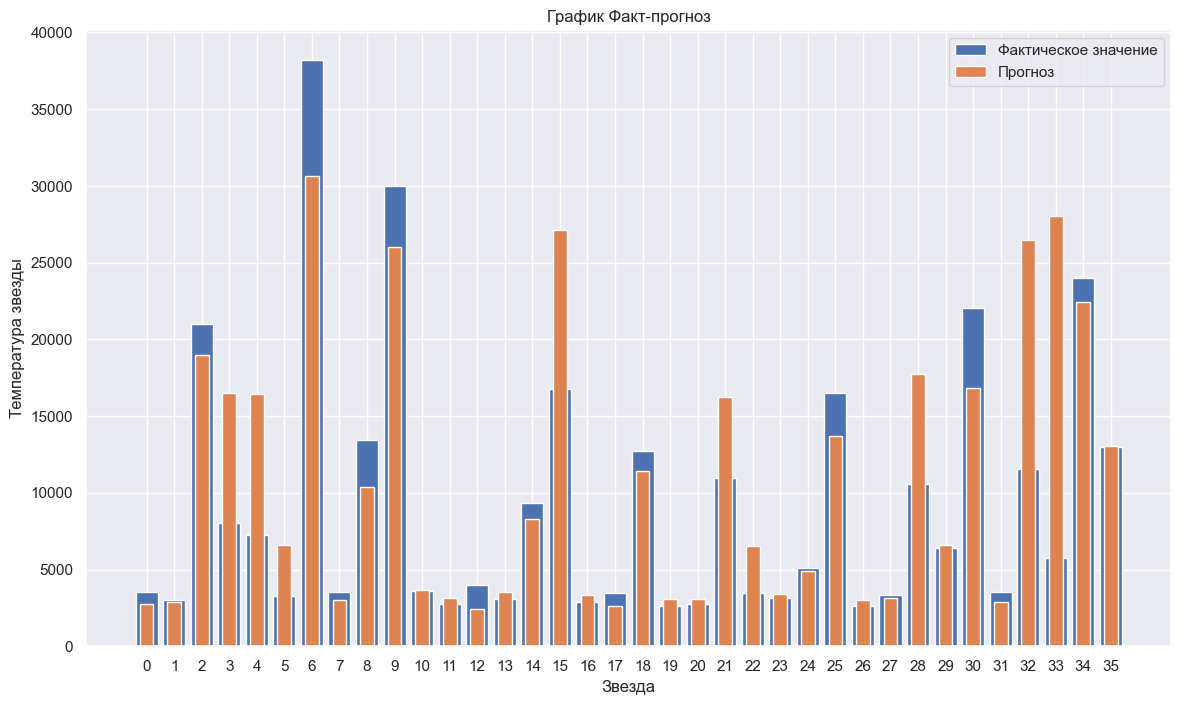

In [390]:
train_net(
    model=test_model,
    X_train=features_train, y_train=target_train,
    X_valid=features_valid, y_valid=target_valid,
    num_epoch=MAX_EPOCHS, learning_rate=.005
)

Судя по графику обучения, данная архитектура не особо лучше прошлой. У нее также после 15000 эпох начинается переобучение. Она также плохо работает со звездами высокой температуры

### Архитектура `13-20-ReLU-12-ReLU-6-ReLU-1`

In [391]:
test_model = StarTemperatureNet(
    input_size=features_test.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    hidden_size_2=12, act_2=nn.ReLU(),
    hidden_size_3=6, act_3=nn.ReLU(),
    name='13-20-relu-12-relu-6-relu-1'
)

Эпоха №100. RMSE_train: 13930.77. RMSE_valid: 12144.80
Эпоха №200. RMSE_train: 7878.79. RMSE_valid: 7688.25
Эпоха №300. RMSE_train: 6969.87. RMSE_valid: 7161.15
Эпоха №400. RMSE_train: 6492.17. RMSE_valid: 6706.36
Эпоха №500. RMSE_train: 6040.38. RMSE_valid: 6334.43
Эпоха №600. RMSE_train: 5547.89. RMSE_valid: 5978.77
Эпоха №700. RMSE_train: 5019.61. RMSE_valid: 5653.17
Эпоха №800. RMSE_train: 4554.08. RMSE_valid: 5423.87
Эпоха №900. RMSE_train: 4265.50. RMSE_valid: 5288.80
Эпоха №1000. RMSE_train: 4079.83. RMSE_valid: 5090.20
Эпоха №1100. RMSE_train: 4001.81. RMSE_valid: 4974.70
Эпоха №1200. RMSE_train: 3957.66. RMSE_valid: 4931.00
Эпоха №1300. RMSE_train: 3927.89. RMSE_valid: 4905.12
Эпоха №1400. RMSE_train: 3908.55. RMSE_valid: 4898.38
Эпоха №1500. RMSE_train: 3895.21. RMSE_valid: 4897.90
Эпоха №1600. RMSE_train: 3882.71. RMSE_valid: 4905.83
Эпоха №1700. RMSE_train: 3846.92. RMSE_valid: 4961.43
Эпоха №1800. RMSE_train: 3831.74. RMSE_valid: 4960.90
Эпоха №1900. RMSE_train: 3822.83. R

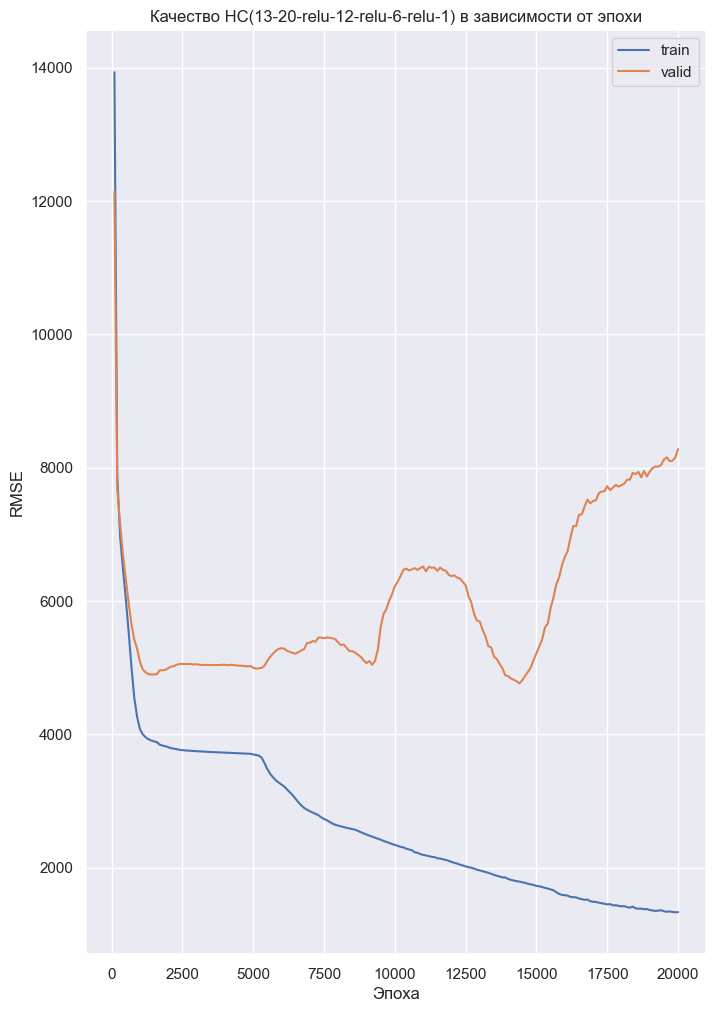

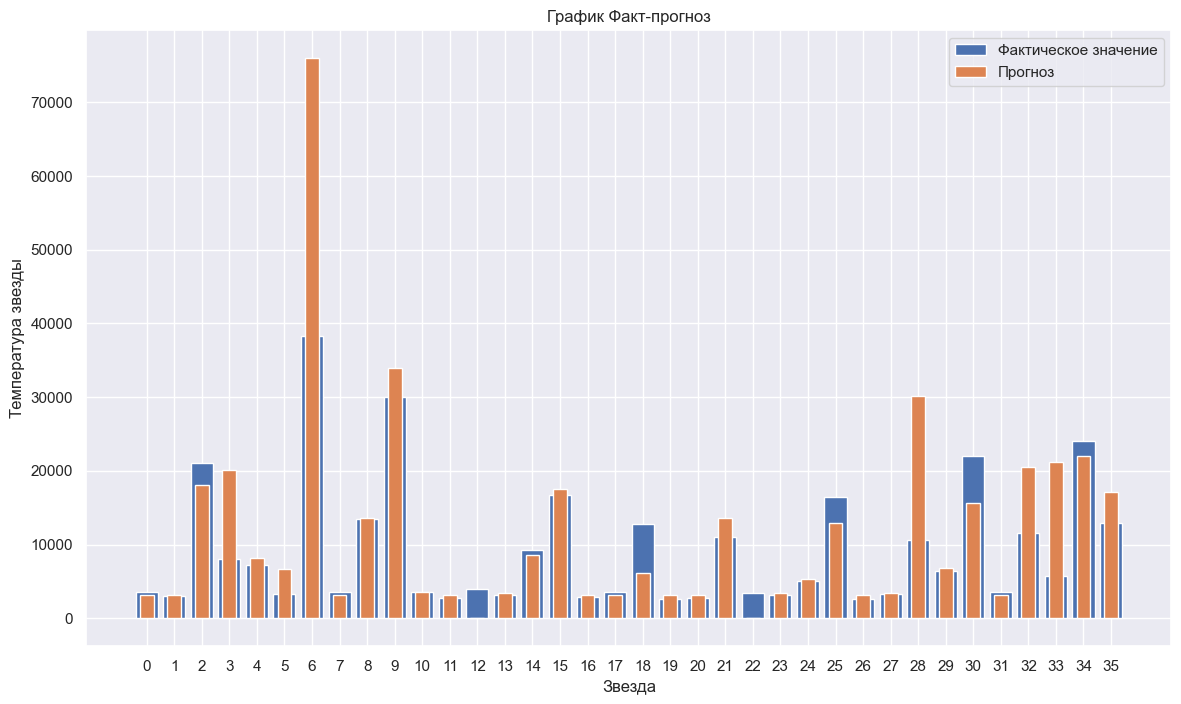

In [392]:
train_net(
    model=test_model,
    X_train=features_train, y_train=target_train,
    X_valid=features_valid, y_valid=target_valid,
    num_epoch=MAX_EPOCHS, learning_rate=.005
)

После добавления 3 слоя, НС стала еще больше переобучаться и производить бОльшие ошибки на валидационных данных. Попробуем заменить одну функцию активации на сигмойду

### Архитектура `13-20-ReLU-16-Sigmoid-12-ReLU-1`

In [407]:
test_model = StarTemperatureNet(
    input_size=features_test.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    hidden_size_2=16, act_2=nn.Sigmoid(),
    hidden_size_3=12, act_3=nn.ReLU(),
    name='13-20-relu-12-relu-1'
)

Эпоха №100. RMSE_train: 14496.79. RMSE_valid: 12625.31
Эпоха №200. RMSE_train: 14356.91. RMSE_valid: 12484.60
Эпоха №300. RMSE_train: 14122.00. RMSE_valid: 12249.47
Эпоха №400. RMSE_train: 13803.46. RMSE_valid: 11932.09
Эпоха №500. RMSE_train: 13417.15. RMSE_valid: 11549.39
Эпоха №600. RMSE_train: 12981.79. RMSE_valid: 11121.53
Эпоха №700. RMSE_train: 12518.10. RMSE_valid: 10671.00
Эпоха №800. RMSE_train: 12047.85. RMSE_valid: 10221.62
Эпоха №900. RMSE_train: 11592.68. RMSE_valid: 9797.04
Эпоха №1000. RMSE_train: 11172.51. RMSE_valid: 9418.74
Эпоха №1100. RMSE_train: 10631.45. RMSE_valid: 8872.37
Эпоха №1200. RMSE_train: 10139.28. RMSE_valid: 8414.94
Эпоха №1300. RMSE_train: 9682.32. RMSE_valid: 7996.26
Эпоха №1400. RMSE_train: 9273.02. RMSE_valid: 7629.22
Эпоха №1500. RMSE_train: 8916.51. RMSE_valid: 7326.85
Эпоха №1600. RMSE_train: 8617.64. RMSE_valid: 7084.28
Эпоха №1700. RMSE_train: 8379.38. RMSE_valid: 6903.87
Эпоха №1800. RMSE_train: 8198.67. RMSE_valid: 6782.85
Эпоха №1900. RMSE

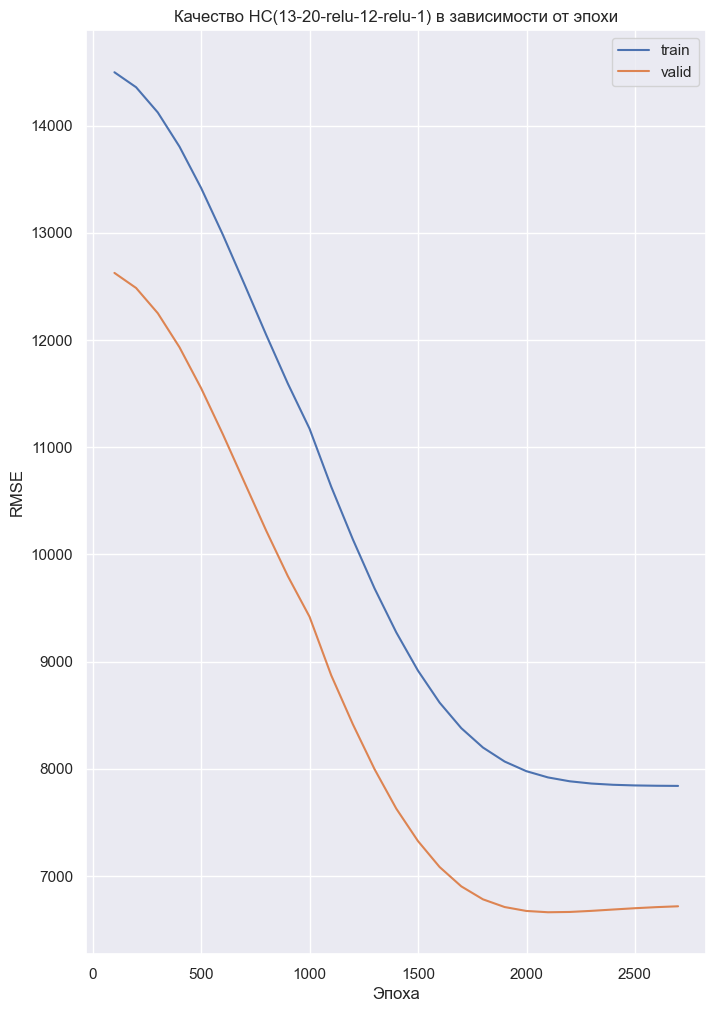

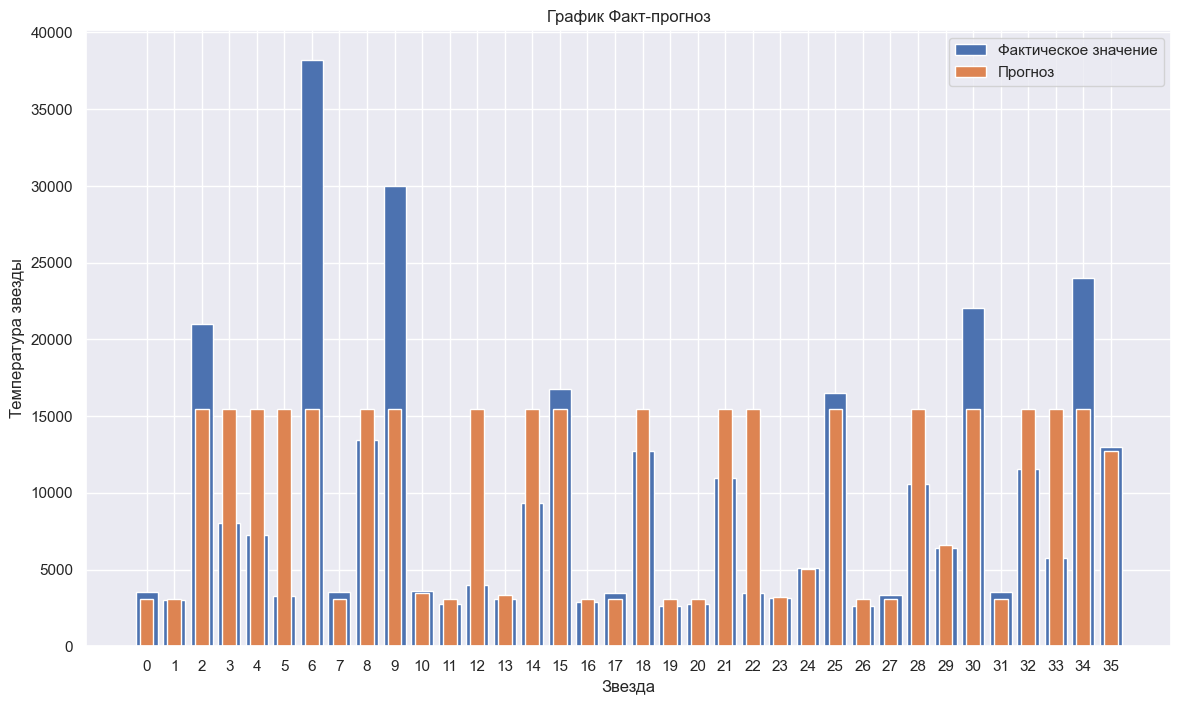

In [408]:
train_net(
    model=test_model,
    X_train=features_train, y_train=target_train,
    X_valid=features_valid, y_valid=target_valid,
    num_epoch=20000, learning_rate=.005
)

В итоге был получен достаточно странный результат. Сеть не выдает значения больше 15000К. Также по графику обучения видно, что на валидационных данных ошибка меньше, чем на тренировочных.

Из EDA было видно, что температура не зависит от параметром `radius` и `luminosity`. Попробуем удалить эти параметры и посмотрим на качество моделей

In [399]:
features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split(
    data.drop(['temperature', 'radius', 'luminosity'], axis=1), data['temperature'], test_size=.3,
    random_state=RANDOM_STATE, stratify=data[['star_color']]
)

In [400]:
features_valid_2, features_test_2, target_valid_2, target_test_2 = train_test_split(
    features_test_2, target_test_2, test_size=.5,
    random_state=RANDOM_STATE, stratify=features_test_2[['star_color']]
)

In [401]:
ohe_encoder = OneHotEncoder(drop='first')

In [402]:
ohe_encoder.fit(features_train_2[['star_type', 'star_color']])

OneHotEncoder(drop='first')

In [403]:
features_train_2 = ohe(features_train_2, ohe_encoder, ['star_type', 'star_color'])
features_valid_2 = ohe(features_valid_2, ohe_encoder, ['star_type', 'star_color'])
features_test_2 = ohe(features_test_2, ohe_encoder, ['star_type', 'star_color'])

In [404]:
numeric = ['abs_magnitude']
scaler = StandardScaler()
scaler.fit(features_train_2[numeric])

StandardScaler()

In [405]:
features_train_2[numeric] = scaler.transform(features_train_2[numeric])
features_valid_2[numeric] = scaler.transform(features_valid_2[numeric])
features_test_2[numeric] = scaler.transform(features_test_2[numeric])

In [406]:
features_train_2 = torch.FloatTensor(features_train_2.values)
target_train_2 = torch.FloatTensor(target_train_2.values)
features_valid_2 = torch.FloatTensor(features_valid_2.values)
target_valid_2 = torch.FloatTensor(target_valid_2.values)
features_test_2 = torch.FloatTensor(features_test_2.values)
target_test_2 = torch.FloatTensor(target_test_2.values)

### Архитектура `11-20-ReLU-1`

In [411]:
test_model = StarTemperatureNet(
    input_size=features_test_2.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    name='11-20-relu-1'
)

Эпоха №100. RMSE_train: 14528.61. RMSE_valid: 12658.17
Эпоха №200. RMSE_train: 14472.19. RMSE_valid: 12604.99
Эпоха №300. RMSE_train: 14370.23. RMSE_valid: 12510.60
Эпоха №400. RMSE_train: 14228.12. RMSE_valid: 12379.81
Эпоха №500. RMSE_train: 14050.13. RMSE_valid: 12216.47
Эпоха №600. RMSE_train: 13840.59. RMSE_valid: 12024.53
Эпоха №700. RMSE_train: 13604.02. RMSE_valid: 11808.13
Эпоха №800. RMSE_train: 13345.11. RMSE_valid: 11571.56
Эпоха №900. RMSE_train: 13068.61. RMSE_valid: 11319.22
Эпоха №1000. RMSE_train: 12779.30. RMSE_valid: 11055.53
Эпоха №1100. RMSE_train: 12481.85. RMSE_valid: 10784.84
Эпоха №1200. RMSE_train: 12180.69. RMSE_valid: 10511.37
Эпоха №1300. RMSE_train: 11879.87. RMSE_valid: 10238.99
Эпоха №1400. RMSE_train: 11582.82. RMSE_valid: 9971.09
Эпоха №1500. RMSE_train: 11292.26. RMSE_valid: 9710.49
Эпоха №1600. RMSE_train: 11010.13. RMSE_valid: 9459.31
Эпоха №1700. RMSE_train: 10737.76. RMSE_valid: 9219.15
Эпоха №1800. RMSE_train: 10476.27. RMSE_valid: 8991.30
Эпоха 

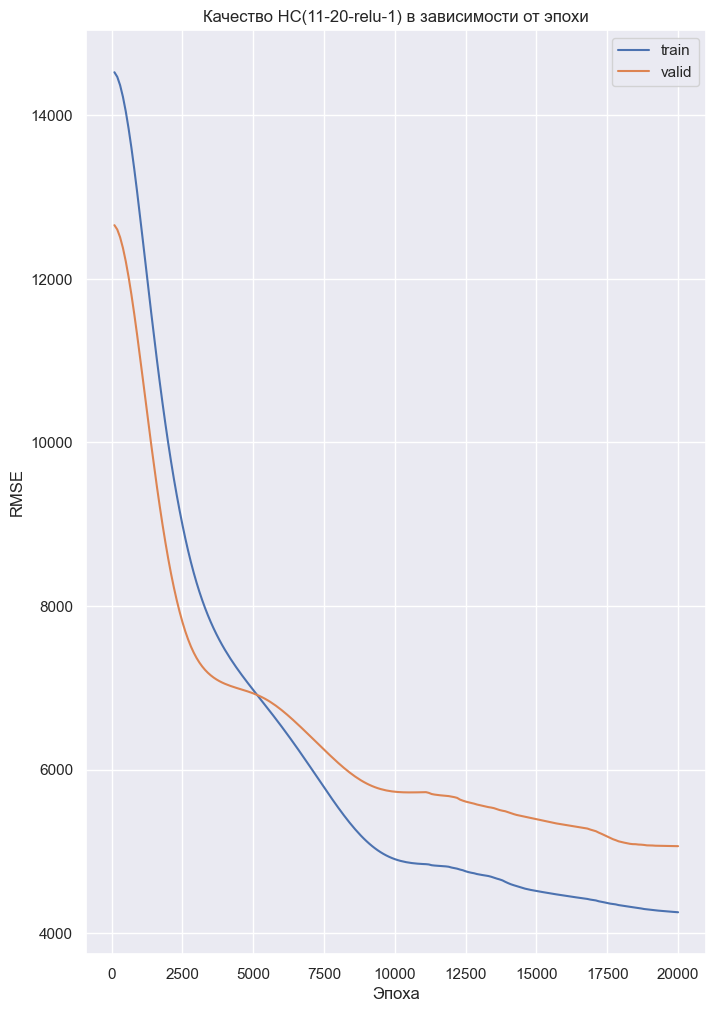

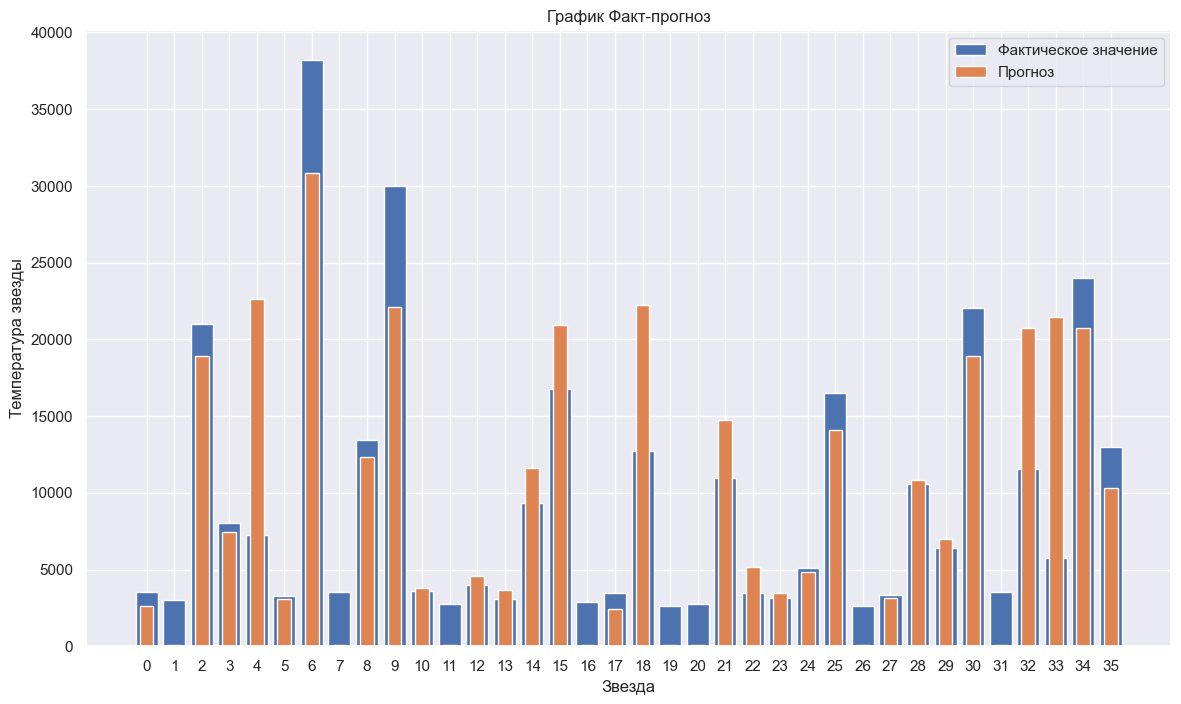

In [412]:
train_net(
    model=test_model,
    X_train=features_train_2, y_train=target_train_2,
    X_valid=features_valid_2, y_valid=target_valid_2,
    num_epoch=MAX_EPOCHS, learning_rate=.005
)

По графику обучения можно подумать, что архитектура стала лучше и сеть перестала переобучаться. Однако график Факт-Прогноз показывает, что сеть стала меньше ошибаться на звездах большой температуры. Однако на звездах с низкой темепературой сеть стала ошибаться гораздо сильнее. На некоторых звездах она даже не выдает адекватный результат

### Архитектура `11-20-ReLU-12-ReLU-1`

In [450]:
test_model = StarTemperatureNet(
    input_size=features_test_2.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    hidden_size_2=12, act_2=nn.ReLU(),
    name='11-20-relu-12-relu-1'
)

Эпоха №100. RMSE_train: 14399.52. RMSE_valid: 12533.11
Эпоха №200. RMSE_train: 12841.81. RMSE_valid: 11078.44
Эпоха №300. RMSE_train: 9943.48. RMSE_valid: 8480.37
Эпоха №400. RMSE_train: 8418.58. RMSE_valid: 7396.51
Эпоха №500. RMSE_train: 7777.99. RMSE_valid: 7115.91
Эпоха №600. RMSE_train: 7371.39. RMSE_valid: 6992.39
Эпоха №700. RMSE_train: 7056.06. RMSE_valid: 6910.34
Эпоха №800. RMSE_train: 6768.83. RMSE_valid: 6811.20
Эпоха №900. RMSE_train: 6482.21. RMSE_valid: 6677.07
Эпоха №1000. RMSE_train: 6185.91. RMSE_valid: 6507.06
Эпоха №1100. RMSE_train: 5880.70. RMSE_valid: 6313.67
Эпоха №1200. RMSE_train: 5575.03. RMSE_valid: 6113.66
Эпоха №1300. RMSE_train: 5286.48. RMSE_valid: 5934.48
Эпоха №1400. RMSE_train: 5042.30. RMSE_valid: 5797.98
Эпоха №1500. RMSE_train: 4855.86. RMSE_valid: 5687.41
Эпоха №1600. RMSE_train: 4717.90. RMSE_valid: 5589.16
Эпоха №1700. RMSE_train: 4607.71. RMSE_valid: 5492.87
Эпоха №1800. RMSE_train: 4514.25. RMSE_valid: 5403.68
Эпоха №1900. RMSE_train: 4433.09.

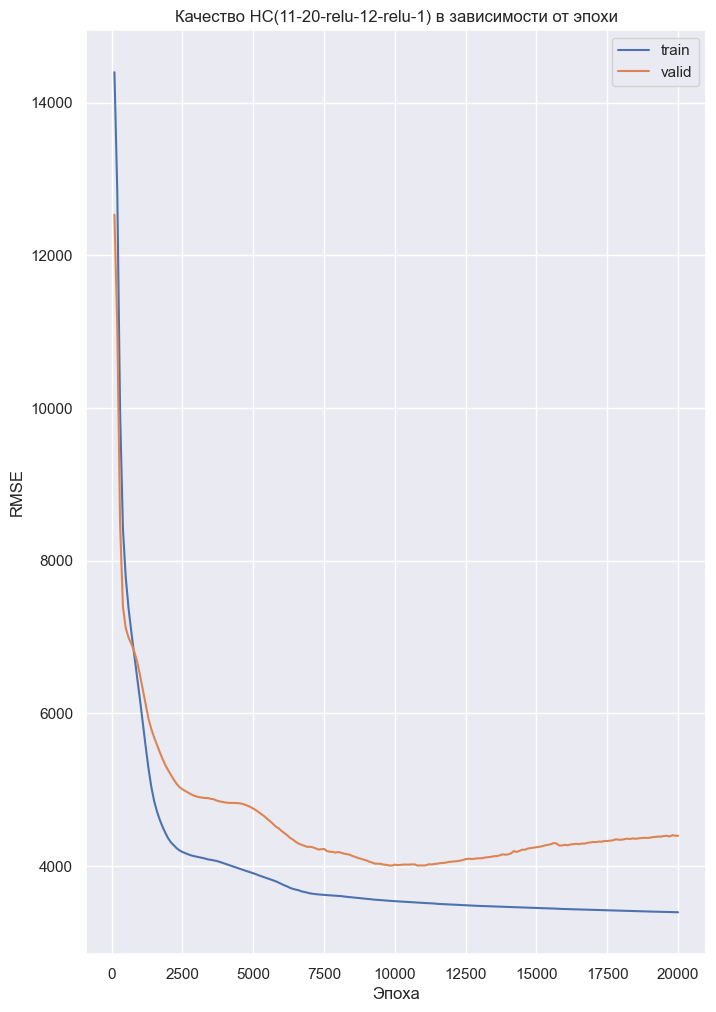

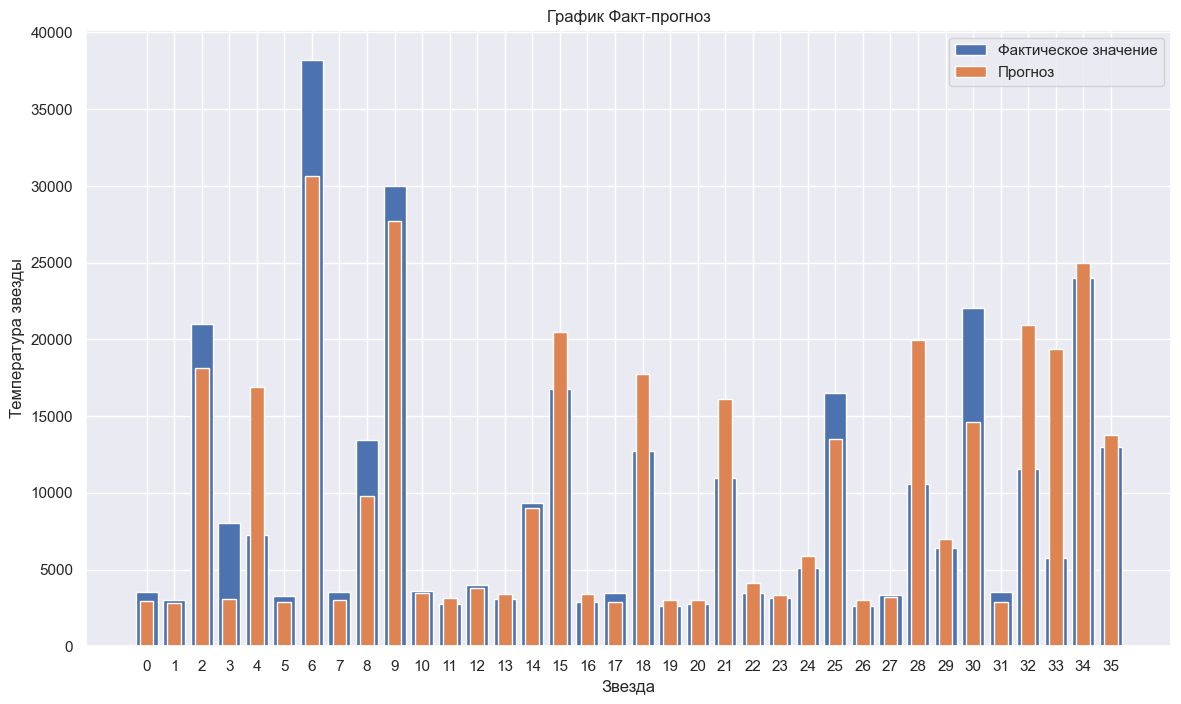

In [451]:
train_net(
    model=test_model,
    X_train=features_train_2, y_train=target_train_2,
    X_valid=features_valid_2, y_valid=target_valid_2,
    num_epoch=MAX_EPOCHS, learning_rate=.005
)

Сеть данной архитектуры стоит обучать не более чем на 10000 эпох. По графику Факт-Прогноз видна стандартная картина - сеть хорошо предсказывает температуру холодных звезды и плохо горячих звезд

### Архитектура `11-20-ReLU-12-ReLU-6-ReLU-1`

In [454]:
test_model = StarTemperatureNet(
    input_size=features_test_2.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    hidden_size_2=12, act_2=nn.ReLU(),
    hidden_size_3=6, act_3=nn.ReLU(),
    name='11-20-relu-12-relu-6-relu-1'
)

Эпоха №100. RMSE_train: 14371.13. RMSE_valid: 12499.72
Эпоха №200. RMSE_train: 10522.12. RMSE_valid: 8915.14
Эпоха №300. RMSE_train: 8186.97. RMSE_valid: 7293.78
Эпоха №400. RMSE_train: 7572.23. RMSE_valid: 7075.33
Эпоха №500. RMSE_train: 7161.55. RMSE_valid: 6973.09
Эпоха №600. RMSE_train: 6757.43. RMSE_valid: 6811.53
Эпоха №700. RMSE_train: 6293.24. RMSE_valid: 6554.24
Эпоха №800. RMSE_train: 5754.21. RMSE_valid: 6219.06
Эпоха №900. RMSE_train: 5188.27. RMSE_valid: 5878.99
Эпоха №1000. RMSE_train: 4753.36. RMSE_valid: 5606.63
Эпоха №1100. RMSE_train: 4520.59. RMSE_valid: 5422.07
Эпоха №1200. RMSE_train: 4352.09. RMSE_valid: 5223.29
Эпоха №1300. RMSE_train: 4257.38. RMSE_valid: 5072.02
Эпоха №1400. RMSE_train: 4205.70. RMSE_valid: 4994.13
Эпоха №1500. RMSE_train: 4173.51. RMSE_valid: 4948.49
Эпоха №1600. RMSE_train: 4150.59. RMSE_valid: 4920.56
Эпоха №1700. RMSE_train: 4132.33. RMSE_valid: 4905.20
Эпоха №1800. RMSE_train: 4117.27. RMSE_valid: 4894.08
Эпоха №1900. RMSE_train: 4106.44. 

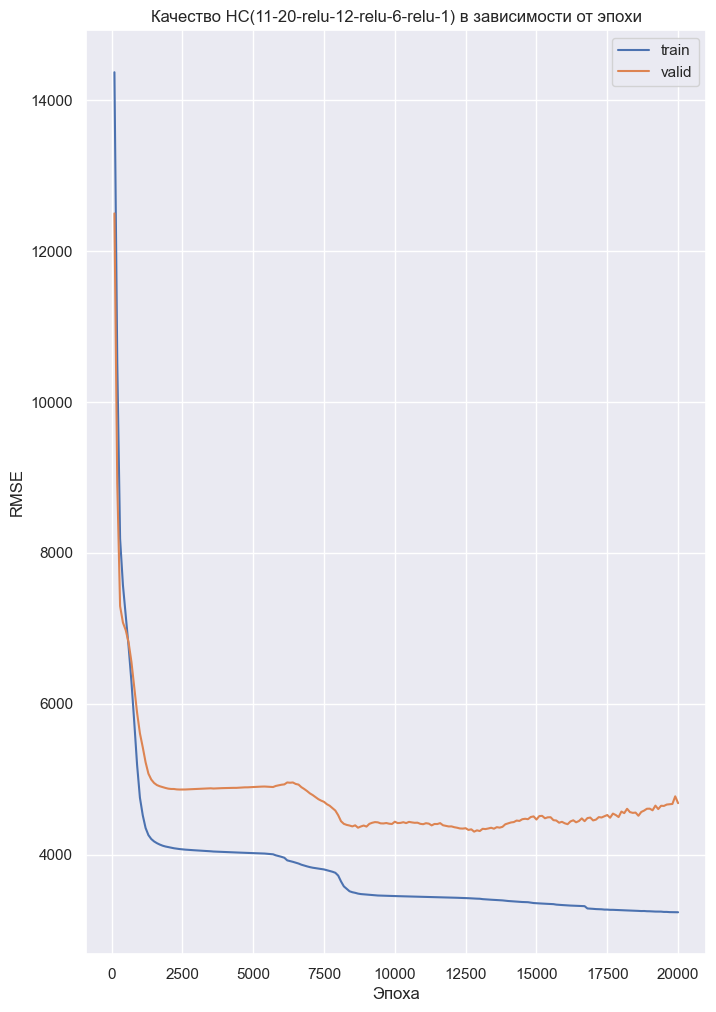

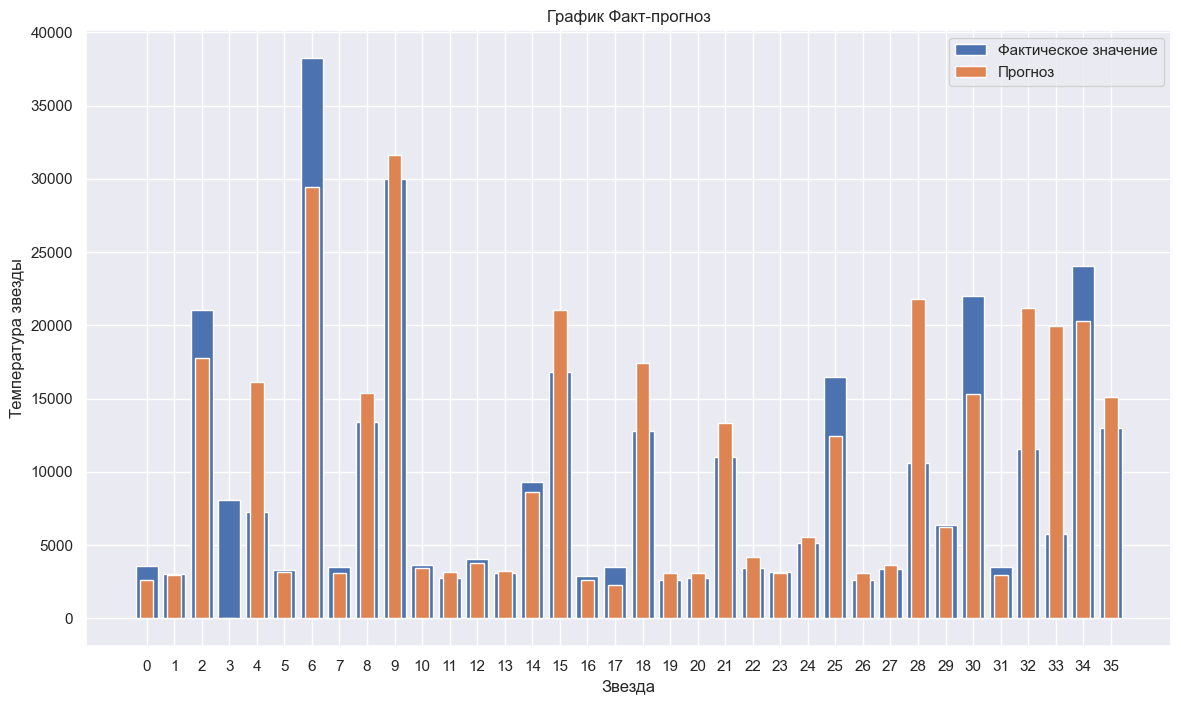

In [455]:
train_net(
    model=test_model,
    X_train=features_train_2, y_train=target_train_2,
    X_valid=features_valid_2, y_valid=target_valid_2,
    num_epoch=MAX_EPOCHS, learning_rate=.005
)

НС данной архитектуры не стоит обучать более чем на 10000 эпохах. Однако все равно наблюдаются большие ошибки в предсказаниях температуры 

### Архитектура `11-20-ReLU-12-Sigmoid-6-ReLU-1`

In [483]:
test_model = StarTemperatureNet(
    input_size=features_test_2.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    hidden_size_2=16, act_2=nn.Sigmoid(),
    hidden_size_3=8, act_3=nn.ReLU(),
    name='11-20-relu-12-sigmoid-6-relu-1'
)

Эпоха №100. RMSE_train: 14525.41. RMSE_valid: 12654.50
Эпоха №200. RMSE_train: 14476.88. RMSE_valid: 12605.66
Эпоха №300. RMSE_train: 14395.55. RMSE_valid: 12524.09
Эпоха №400. RMSE_train: 14283.04. RMSE_valid: 12411.50
Эпоха №500. RMSE_train: 14141.76. RMSE_valid: 12270.40
Эпоха №600. RMSE_train: 13974.49. RMSE_valid: 12103.70
Эпоха №700. RMSE_train: 13784.25. RMSE_valid: 11914.57
Эпоха №800. RMSE_train: 13574.20. RMSE_valid: 11706.40
Эпоха №900. RMSE_train: 13347.67. RMSE_valid: 11482.71
Эпоха №1000. RMSE_train: 13108.04. RMSE_valid: 11247.14
Эпоха №1100. RMSE_train: 12858.79. RMSE_valid: 11003.46
Эпоха №1200. RMSE_train: 12603.40. RMSE_valid: 10755.45
Эпоха №1300. RMSE_train: 12345.37. RMSE_valid: 10506.96
Эпоха №1400. RMSE_train: 12088.14. RMSE_valid: 10261.76
Эпоха №1500. RMSE_train: 11835.08. RMSE_valid: 10023.55
Эпоха №1600. RMSE_train: 11589.41. RMSE_valid: 9795.87
Эпоха №1700. RMSE_train: 11354.12. RMSE_valid: 9581.96
Эпоха №1800. RMSE_train: 11044.17. RMSE_valid: 9263.26
Эпох

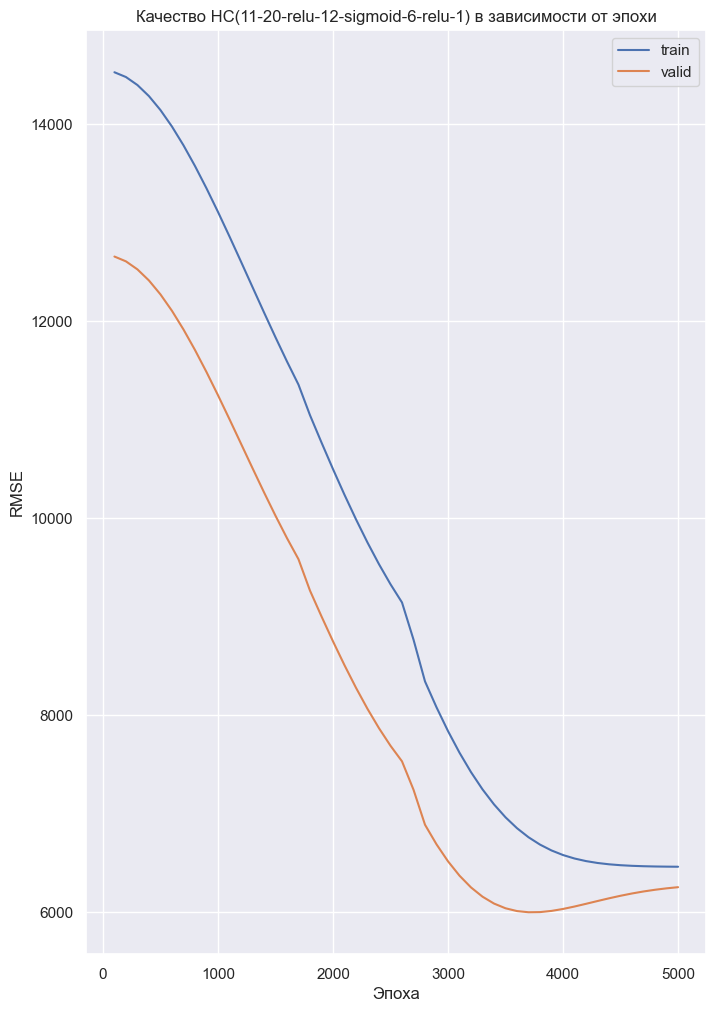

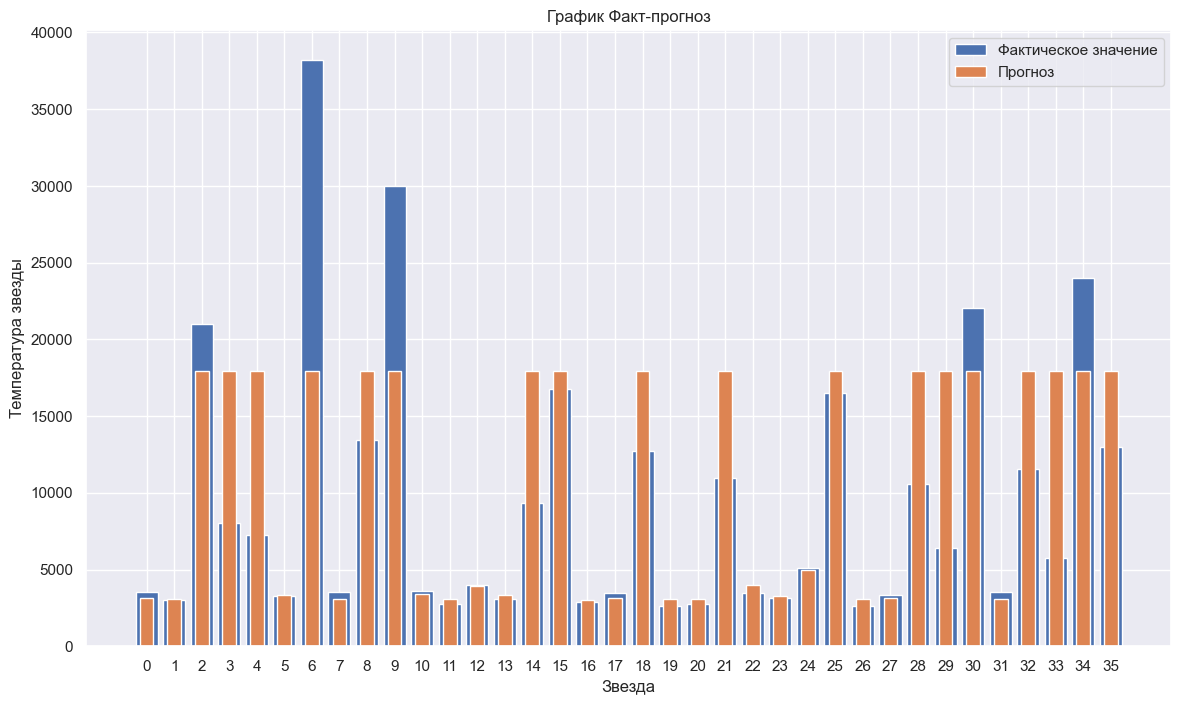

In [484]:
train_net(
    model=test_model,
    X_train=features_train_2, y_train=target_train_2,
    X_valid=features_valid_2, y_valid=target_valid_2,
    num_epoch=MAX_EPOCHS, learning_rate=.005
)

В итоге был получен достаточно странный результат. Сеть не выдает значения больше 17000К. Также по графику обучения видно, что на валидационных данных ошибка меньше, чем на тренировочных.

### Вывод
В ходе экспериментов был протестирован ряд акрхитектур НС. Сети с одним скрытым слоем имеют меньшую обобщающую способность и следовательно большую ошибкую. Архитектыры сетей с двумя скрытыми слоями хорошо предсказывалют температуру холодных звезд, но имеют большие ошибки на предсказаниях температуры горячих звезд. Сети с тремя скрытыми слоями имеют большую склонность к переобучению.  
В итоге для дальшейших экспериментов и улучшений была выбрана архитектура `11-20-ReLU-12-ReLU-1`

## Улучшение нейронной сети

### Архитектура `11-20-DO-ReLU-12-DO-ReLU-1`

In [548]:
test_model = StarTemperatureNet(
    input_size=features_test_2.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(), reg_1=nn.Dropout(p=.3),
    hidden_size_2=12, act_2=nn.ReLU(), reg_2=nn.Dropout(p=.3),
    name='11-20-DO-relu-12-DO-relu1'
)

Эпоха №100. RMSE_train: 14539.59. RMSE_valid: 12669.05
Эпоха №200. RMSE_train: 14530.08. RMSE_valid: 12659.04
Эпоха №300. RMSE_train: 14496.13. RMSE_valid: 12629.82
Эпоха №400. RMSE_train: 14421.53. RMSE_valid: 12560.20
Эпоха №500. RMSE_train: 14307.52. RMSE_valid: 12452.28
Эпоха №600. RMSE_train: 14131.35. RMSE_valid: 12290.17
Эпоха №700. RMSE_train: 13906.48. RMSE_valid: 12081.23
Эпоха №800. RMSE_train: 13612.55. RMSE_valid: 11864.89
Эпоха №900. RMSE_train: 13271.96. RMSE_valid: 11531.01
Эпоха №1000. RMSE_train: 13039.63. RMSE_valid: 11136.85
Эпоха №1100. RMSE_train: 12417.86. RMSE_valid: 10708.82
Эпоха №1200. RMSE_train: 11986.53. RMSE_valid: 10431.51
Эпоха №1300. RMSE_train: 11617.92. RMSE_valid: 10078.28
Эпоха №1400. RMSE_train: 11317.62. RMSE_valid: 9765.57
Эпоха №1500. RMSE_train: 10665.40. RMSE_valid: 9160.17
Эпоха №1600. RMSE_train: 10132.92. RMSE_valid: 8688.24
Эпоха №1700. RMSE_train: 9511.32. RMSE_valid: 9670.00
Эпоха №1800. RMSE_train: 9823.27. RMSE_valid: 8615.53
Эпоха №1

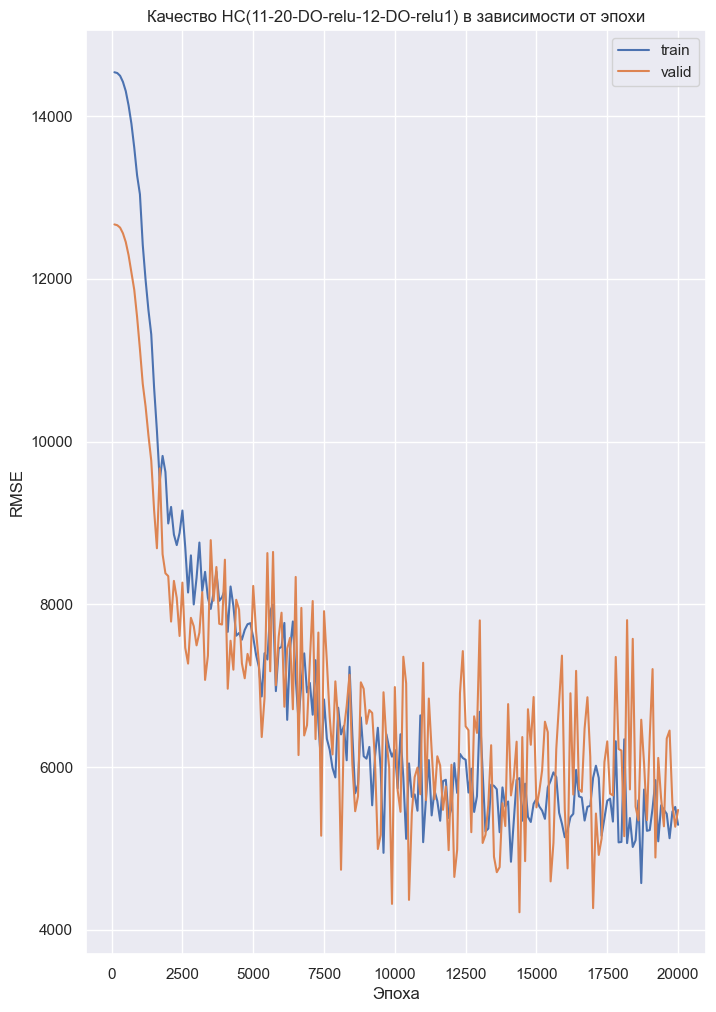

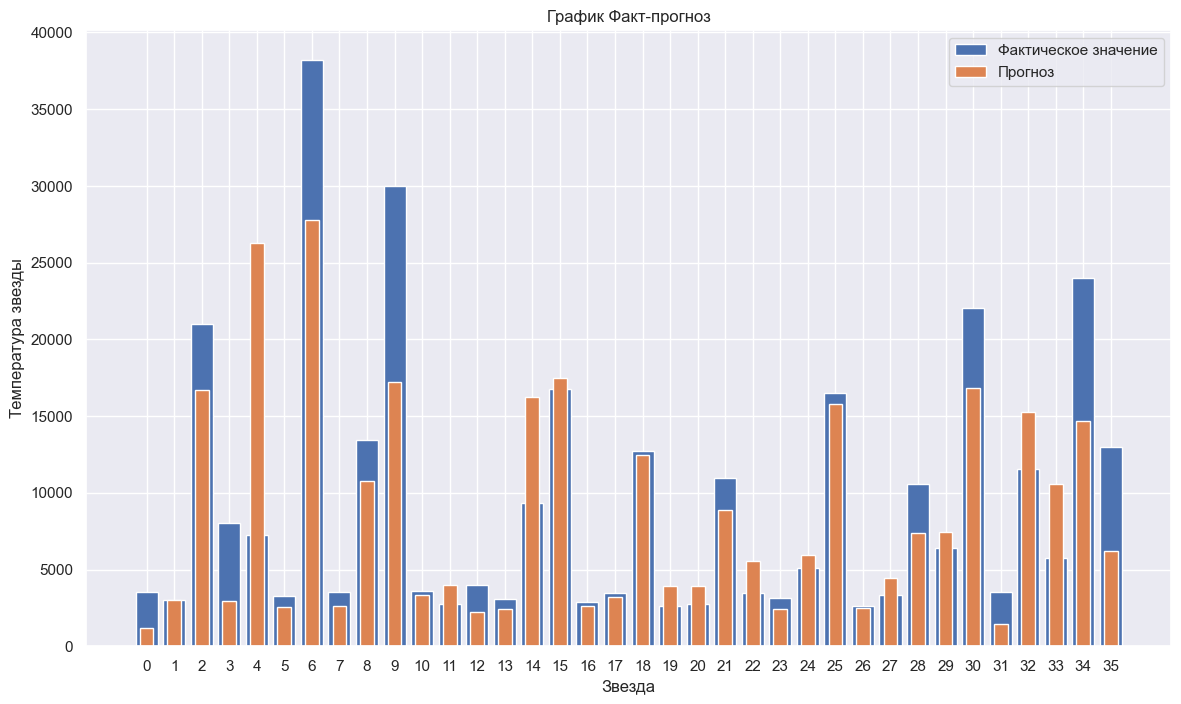

In [549]:
train_net(
    model=test_model,
    X_train=features_train_2, y_train=target_train_2,
    X_valid=features_valid_2, y_valid=target_valid_2,
    num_epoch=MAX_EPOCHS, learning_rate=.001
)

С добавлением DropOut график обучения НС стал более дерганным. Однако нельзя сказать, что предсказательная способность сети улучшилась.

### Архитектура `11-20-BN-ReLU-12-BN-ReLU-1`

In [529]:
test_model = StarTemperatureNet(
    input_size=features_test_2.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(), reg_1=nn.BatchNorm1d(20),
    hidden_size_2=12, act_2=nn.ReLU(), reg_2=nn.BatchNorm1d(12),
    name='11-20-BN-relu-12-BN-relu1'
)

Эпоха №100. RMSE_train: 14539.79. RMSE_valid: 12669.27
Эпоха №200. RMSE_train: 14538.57. RMSE_valid: 12668.08
Эпоха №300. RMSE_train: 14536.69. RMSE_valid: 12666.33
Эпоха №400. RMSE_train: 14534.14. RMSE_valid: 12663.97
Эпоха №500. RMSE_train: 14530.98. RMSE_valid: 12661.01
Эпоха №600. RMSE_train: 14526.44. RMSE_valid: 12656.05
Эпоха №700. RMSE_train: 14521.44. RMSE_valid: 12651.12
Эпоха №800. RMSE_train: 14514.38. RMSE_valid: 12644.74
Эпоха №900. RMSE_train: 14506.61. RMSE_valid: 12637.28
Эпоха №1000. RMSE_train: 14498.35. RMSE_valid: 12629.46
Эпоха №1100. RMSE_train: 14489.50. RMSE_valid: 12620.71
Эпоха №1200. RMSE_train: 14480.10. RMSE_valid: 12611.64
Эпоха №1300. RMSE_train: 14470.14. RMSE_valid: 12601.74
Эпоха №1400. RMSE_train: 14459.54. RMSE_valid: 12591.60
Эпоха №1500. RMSE_train: 14448.44. RMSE_valid: 12580.72
Эпоха №1600. RMSE_train: 14436.82. RMSE_valid: 12569.52
Эпоха №1700. RMSE_train: 14424.67. RMSE_valid: 12557.72
Эпоха №1800. RMSE_train: 14412.01. RMSE_valid: 12545.33
Э

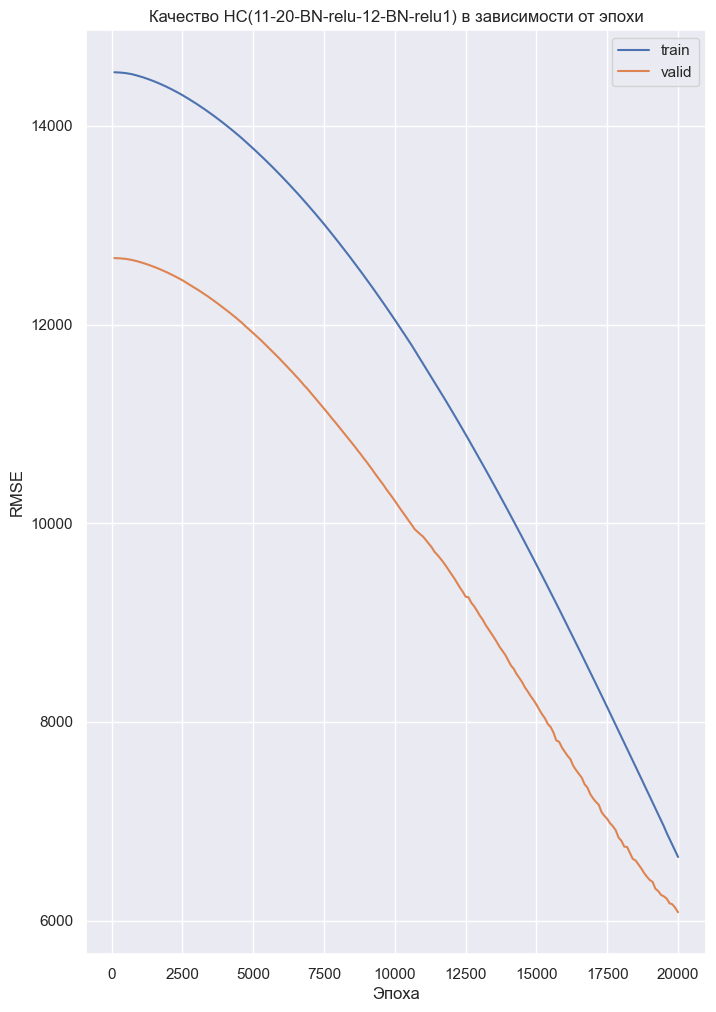

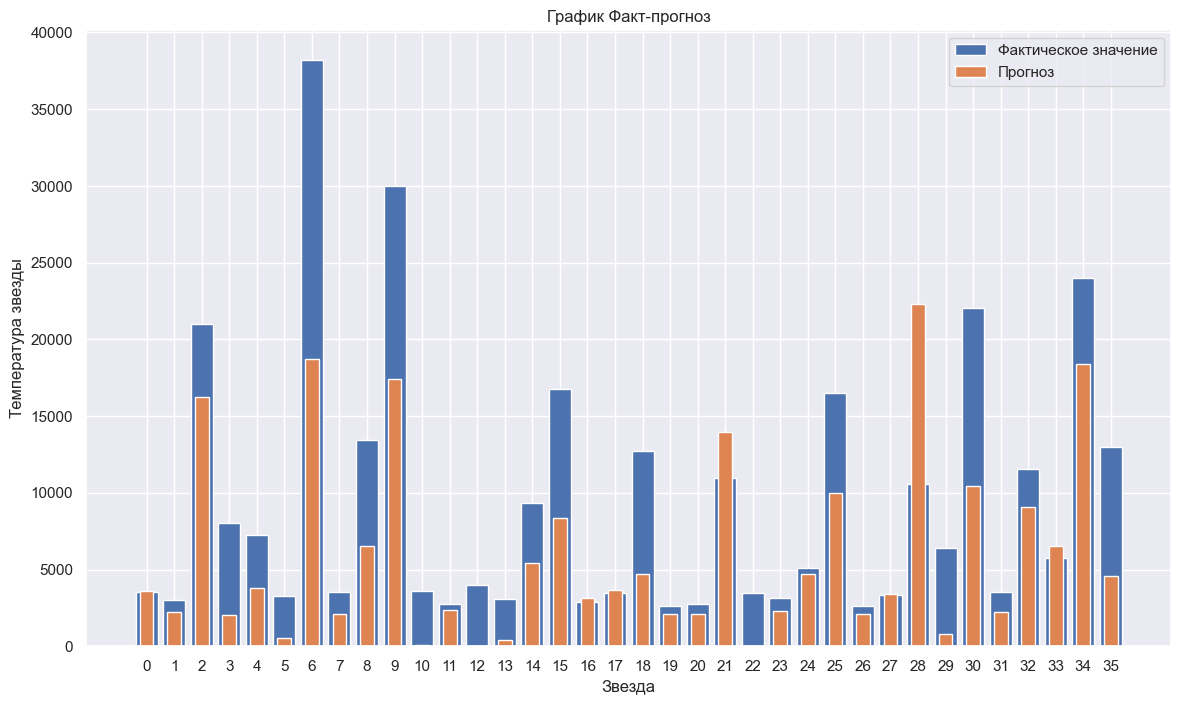

In [530]:
train_net(
    model=test_model,
    X_train=features_train_2, y_train=target_train_2,
    X_valid=features_valid_2, y_valid=target_valid_2,
    num_epoch=MAX_EPOCHS, learning_rate=.001
)

По графику обучения видно, что на протяжении всего процесса обучения качество модели улучшалось. Однако итоговое качество хуже, чем до добавления регуляризации. Попробуем дообучить сеть еще на 20000 эпохах, но уже с меньшим lr

Эпоха №100. RMSE_train: 6632.45. RMSE_valid: 6083.24
Эпоха №200. RMSE_train: 6626.07. RMSE_valid: 6081.22
Эпоха №300. RMSE_train: 6619.70. RMSE_valid: 6082.73
Эпоха №400. RMSE_train: 6613.30. RMSE_valid: 6083.25
Эпоха №500. RMSE_train: 6606.94. RMSE_valid: 6083.56
Эпоха №600. RMSE_train: 6600.55. RMSE_valid: 6081.78
Эпоха №700. RMSE_train: 6594.17. RMSE_valid: 6080.03
Эпоха №800. RMSE_train: 6587.78. RMSE_valid: 6075.28
Эпоха №900. RMSE_train: 6581.39. RMSE_valid: 6074.63
Эпоха №1000. RMSE_train: 6575.01. RMSE_valid: 6076.52
Эпоха №1100. RMSE_train: 6568.62. RMSE_valid: 6073.25
Эпоха №1200. RMSE_train: 6562.24. RMSE_valid: 6071.93
Эпоха №1300. RMSE_train: 6555.85. RMSE_valid: 6067.97
Эпоха №1400. RMSE_train: 6549.47. RMSE_valid: 6064.77
Эпоха №1500. RMSE_train: 6543.09. RMSE_valid: 6066.39
Эпоха №1600. RMSE_train: 6536.67. RMSE_valid: 6059.85
Эпоха №1700. RMSE_train: 6530.29. RMSE_valid: 6061.31
Эпоха №1800. RMSE_train: 6523.89. RMSE_valid: 6058.12
Эпоха №1900. RMSE_train: 6517.53. RMS

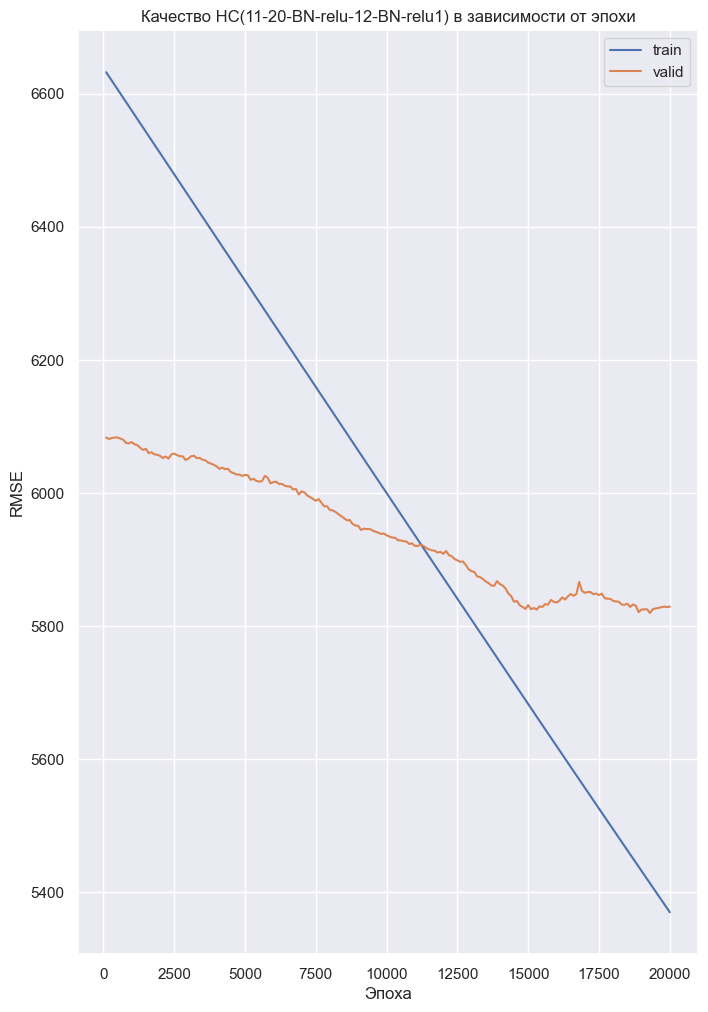

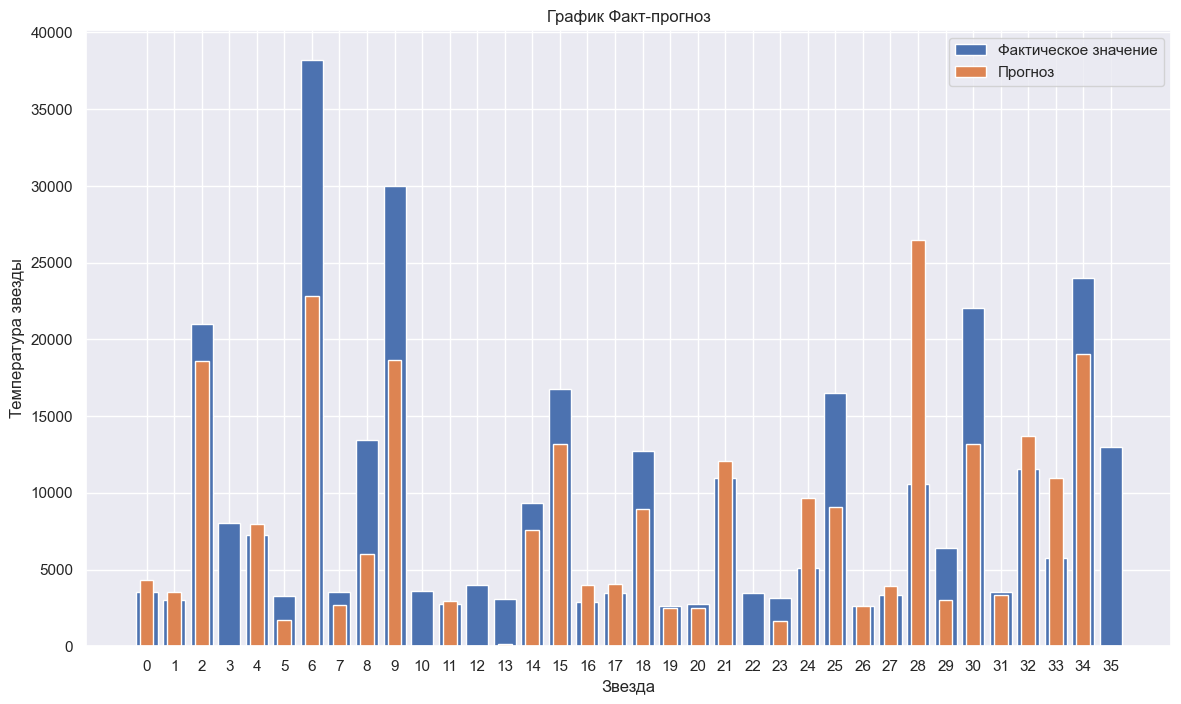

In [531]:
train_net(
    model=test_model,
    X_train=features_train_2, y_train=target_train_2,
    X_valid=features_valid_2, y_valid=target_valid_2,
    num_epoch=MAX_EPOCHS, learning_rate=.0001
)

В итоге все равно не получилось добиться лучшего качества, чем было до добавления BatchNorm

### Вывод
Добавление регуляризации не помогло улучшить работу выбранной архитектуры НС. Поэтому оставим архитектуру `11-20-ReLU-12-ReLU-1` в качестве конечного результата и проверим ее работу на тестовом датасете

Эпоха №100. RMSE_train: 14485.79. RMSE_valid: 12618.32
Эпоха №200. RMSE_train: 13799.39. RMSE_valid: 11983.72
Эпоха №300. RMSE_train: 11946.46. RMSE_valid: 10290.26
Эпоха №400. RMSE_train: 9861.52. RMSE_valid: 8454.05
Эпоха №500. RMSE_train: 8647.90. RMSE_valid: 7563.30
Эпоха №600. RMSE_train: 8031.12. RMSE_valid: 7267.12
Эпоха №700. RMSE_train: 7645.08. RMSE_valid: 7117.72
Эпоха №800. RMSE_train: 7360.86. RMSE_valid: 7036.87
Эпоха №900. RMSE_train: 7122.98. RMSE_valid: 6976.80
Эпоха №1000. RMSE_train: 6895.43. RMSE_valid: 6905.76
Эпоха №1100. RMSE_train: 6656.73. RMSE_valid: 6808.28
Эпоха №1200. RMSE_train: 6402.47. RMSE_valid: 6680.34
Эпоха №1300. RMSE_train: 6127.54. RMSE_valid: 6524.53
Эпоха №1400. RMSE_train: 5834.91. RMSE_valid: 6341.35
Эпоха №1500. RMSE_train: 5530.38. RMSE_valid: 6147.21
Эпоха №1600. RMSE_train: 5236.49. RMSE_valid: 5956.62
Эпоха №1700. RMSE_train: 4983.11. RMSE_valid: 5793.03
Эпоха №1800. RMSE_train: 4789.78. RMSE_valid: 5673.58
Эпоха №1900. RMSE_train: 4649.8

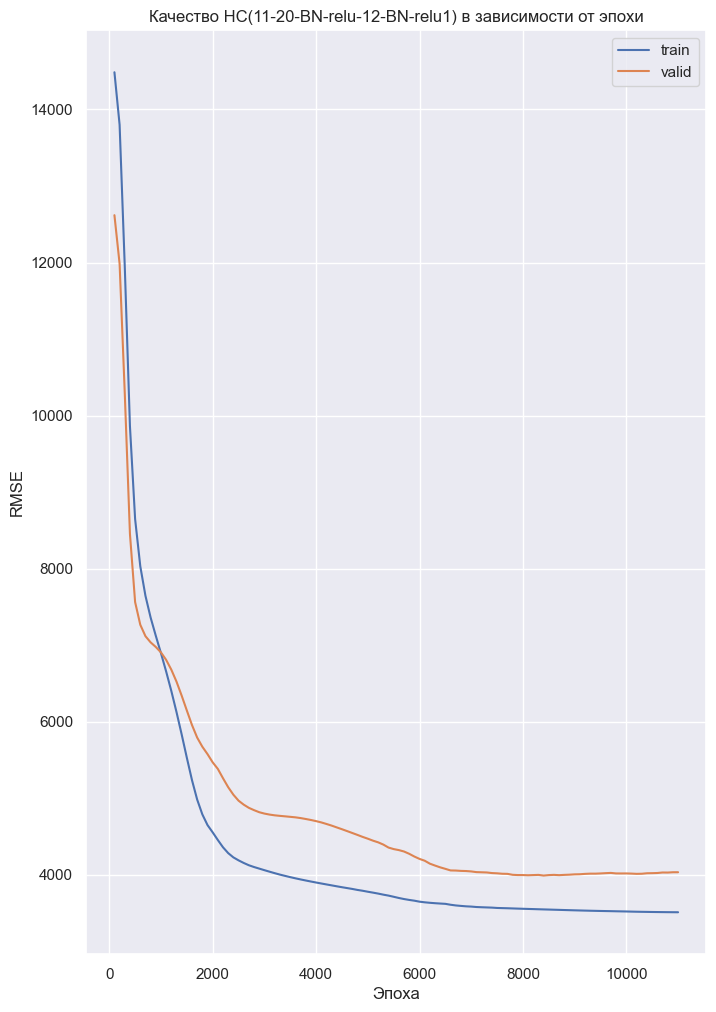

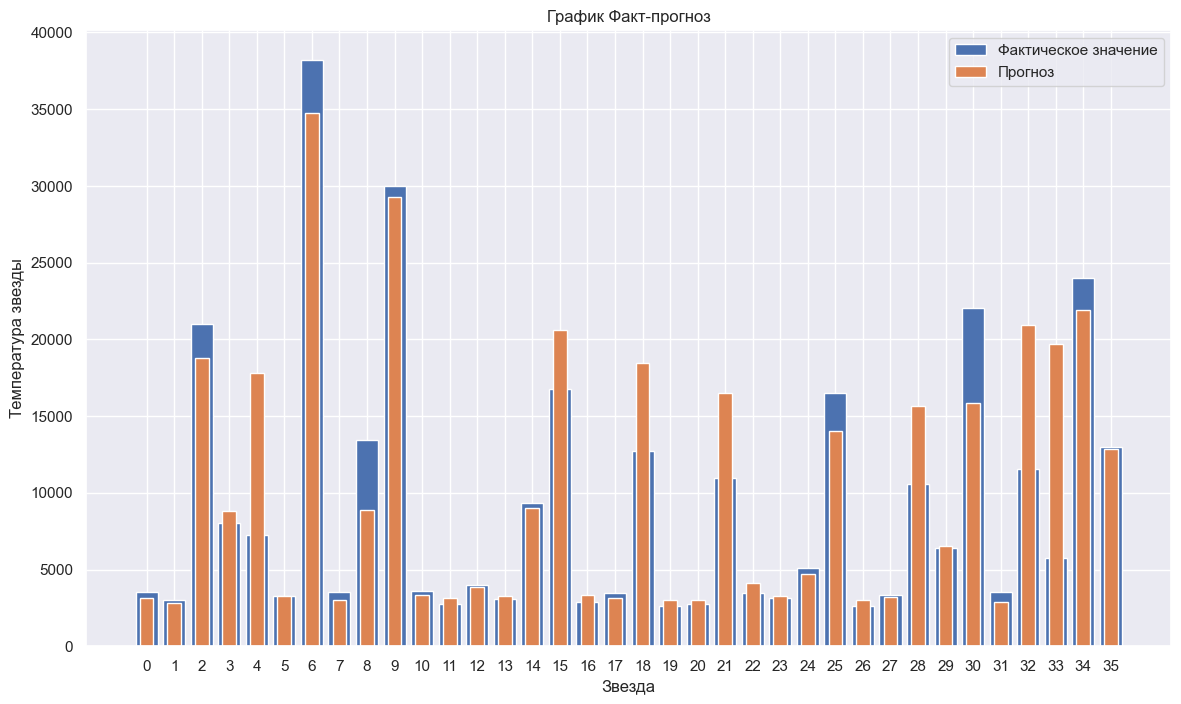

In [551]:
model = StarTemperatureNet(
    input_size=features_test_2.shape[1],
    hidden_size_1=20, act_1=nn.ReLU(),
    hidden_size_2=12, act_2=nn.ReLU(),
    name='11-20-BN-relu-12-BN-relu1'
)
train_net(
    model=model,
    X_train=features_train_2, y_train=target_train_2,
    X_valid=features_valid_2, y_valid=target_valid_2,
    num_epoch=MAX_EPOCHS, learning_rate=.005
)

На тестовой выборке RMSE = 4039.67


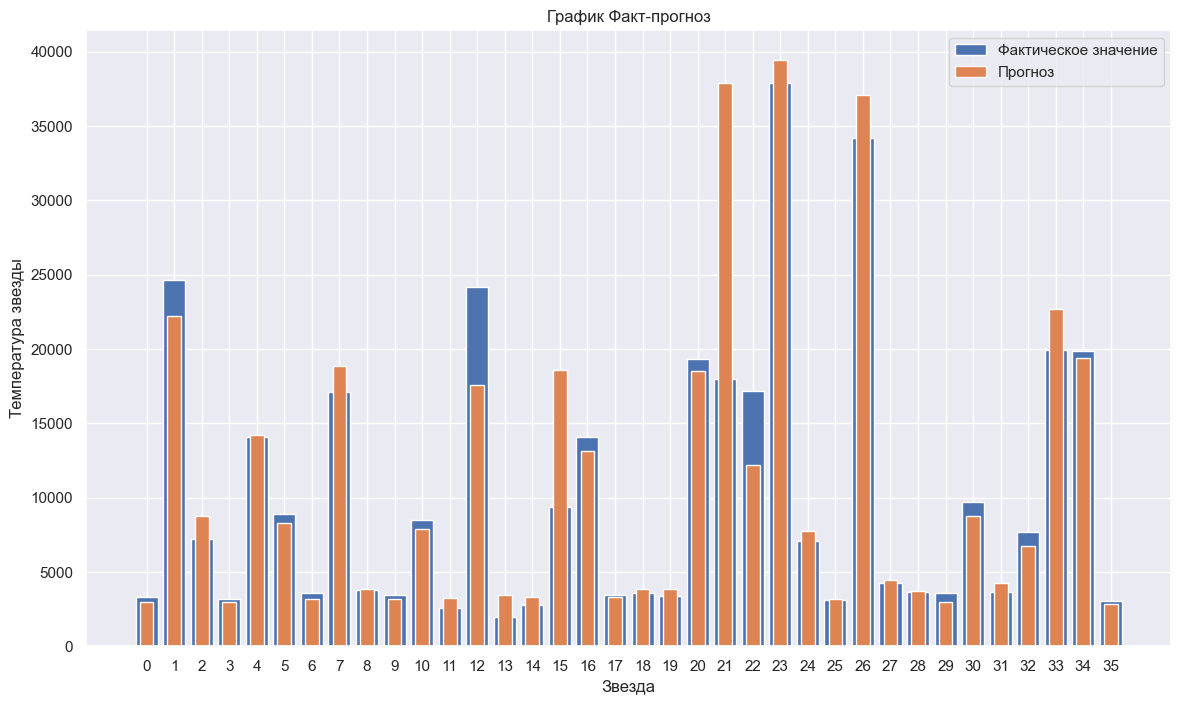

In [554]:
loss = nn.MSELoss()
with torch.no_grad():
    pred_test = model(features_test_2).flatten()
    loss_value = loss(pred_test, target_test_2)
    rmse_test = torch.sqrt(loss_value)
    print(f'На тестовой выборке RMSE = {rmse_test:.2f}')
    predict_fact_schedule(pred_test, target_test_2)

## Выводы

В ходе выполнения задачи был проведен анализ данных в ходе которого были удалены неявные дубликаты из признака `цвет звезды`. Также было выяснено, что в данных серьезный дисбаланс по цвету звезд. Некоторые категории были совсем маленькие и их пришлось объединять. Размер датасета и дисбаланс данных мог серьезно повлиять на конечный результат.  
Далее в ходе экспериментов было обучено множество различных полносвязных архитектур нейронных сетей. На основании полученных данных и графиков в качестве лучшей была выбрана архитектура `11-20-ReLU-12-ReLU-1`.  
В дальнейшем были предприяты попытки улучшить данную акхитектуру за счет добавления нормализации (DropoOut и BatchNorm), увеличения колчества эпох и изменяния скорости обучения. Ни один из экспериментов не привел к улучшени. модели. В итоге было принято решение в качестве финальной использовать модель `11-20-ReLU-12-ReLU-1`.
На тестовой выборке RMSE модели оказался равен `4039.67`, что удовлетворяет поставленной задаче. Итоговая модель хорошо предсказывает температуру холодных звезд (до 9000-1000К), но допускает большие ошибки при предсказании температуры горячих звезд.    
В качестве дальнейших улучшений необходимо поработать с датасетом:
1. Расширить его.
2. Уменьшить дисбаланс данных